# Analyzing social network graph (VK) ● Alyaxey Yaskevich

In [1]:
%matplotlib inline
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from IPython.display import HTML
from IPython.core.display import Image, display
import colorlover as cl
import plotly.offline as py
from plotly.graph_objs import *
import community
import seaborn as sns
from collections import Counter
from matplotlib import cm
from networkx.algorithms import community as nxcom
from collections import defaultdict

## 1. Summary

#### Data loading

This graph is provided by my friend, as soon as I don't use VK network actively. However, I can not add additonal attributes to nodes, because I don't know most of these people. Also, in data analysis and visualizations I use only first names and ID derivatives due to privacy considerations.

In [2]:
# with open('vk-friends-21060831.gexf', encoding="utf-8") as file:
#     some = file.read()
#     some = re.sub('\[object Object\]', '1', some)
#     with open('vk_friends2.gexf', 'w', encoding="utf-8") as file2:
#         file2.write(some)

G = nx.read_gexf('vk_friends2.gexf').to_undirected()
# vars(G)

#### Graph information

In [3]:
print(nx.info(G))
print ("Number of connected components", nx.number_connected_components(G))

Name: 
Type: Graph
Number of nodes: 157
Number of edges: 501
Average degree:   6.3822
Number of connected components 27


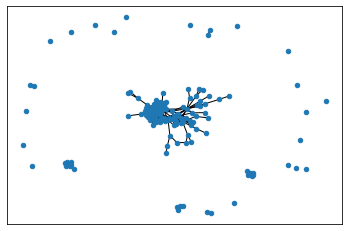

In [4]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos = pos, with_labels=False, node_size = 20)

As one can, there is a lot of singletons, which obviously cannot make a community, so let's get rid of them.

In [5]:
G.remove_nodes_from(list(nx.isolates(G)))

In [6]:
print(nx.info(G))
print ("Number of connected components", nx.number_connected_components(G))

Name: 
Type: Graph
Number of nodes: 138
Number of edges: 501
Average degree:   7.2609
Number of connected components 8


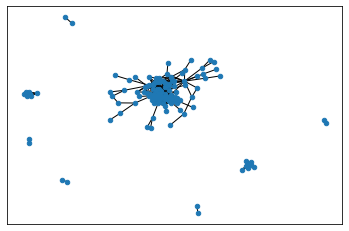

In [7]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos = pos, with_labels=False, node_size = 20)

We use this distilled version of graph further.

In [8]:
print("Graph size:", G.size())
print("Graph order:", G.order())

Graph size: 501
Graph order: 138


In [9]:
# vars(G)

In [10]:
# matplotlib.rcParams.update({'font.size': 22})
lbls =  {n: d["first_name"]+n[:2] for n, d in G.nodes(data=True)}
# lbls =  {n: d["label"] for n, d in G.nodes(data=True)}
# lbls

#### Node attributes
Unfortunately, recommended app which produced the graph cannot access all the attributes, as date of birth or city/country. Data of birth is accessible only for some users, but location is the same for all users.

Features provided for every node:
* id
* first name
* last name
* gender
* personal relations status (most, but not every)

In [11]:
rels = { "1": "single",
        "2":"in a relationship",
        "3":"engaged",
        "4":"married",
        "5":"it's complicated", 
        "6":"actively searching",
        "7":"in love", 
        "8":"in a civil union",
        "0" : "not specified" }

cnt_rels = Counter()
cnt_gen = Counter()
for n, gn in G.nodes(data=True):    
    the_rel = rels[str(gn["relation"])]  if "relation" in gn else rels["0"]
    the_gen = "F" if gn['sex'] == 1 else "M"
    cnt_gen[the_gen] += 1
    cnt_rels[the_rel] += 1
print(cnt_gen)

Counter({'F': 109, 'M': 29})


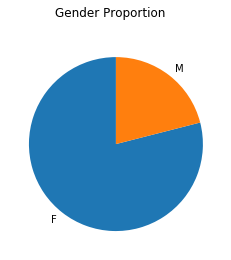

In [12]:
data = dict(cnt_gen)
names = list(data.keys())
values = list(data.values())

plt.rcParams.update({'font.size': 10})
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=names, startangle=90)
fig1.suptitle('Gender Proportion')
plt.show()

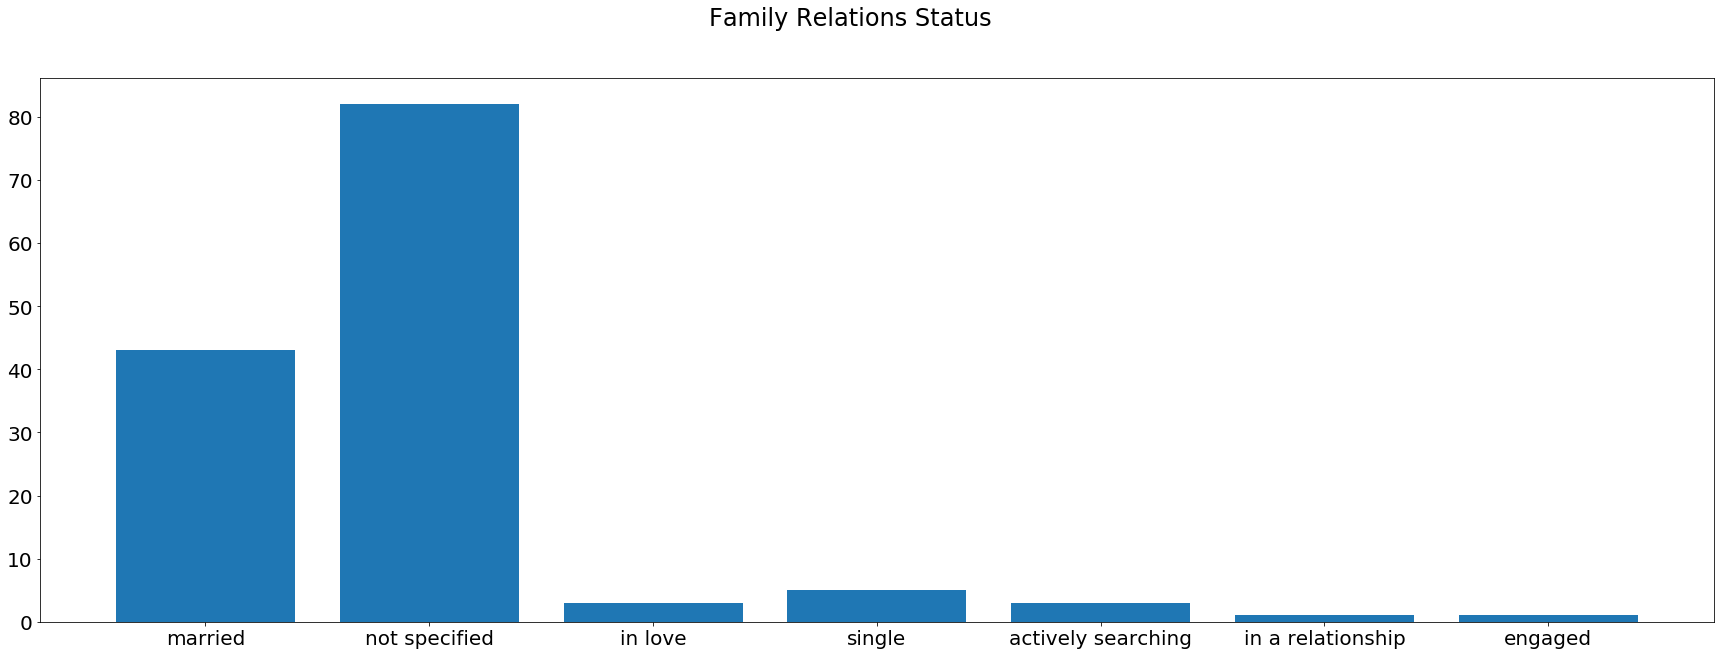

In [13]:
data = dict(cnt_rels)
names = list(data.keys())
values = list(data.values())

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(30, 10))
ax.bar(names, values)

fig.suptitle('Family Relations Status')

plt.show()

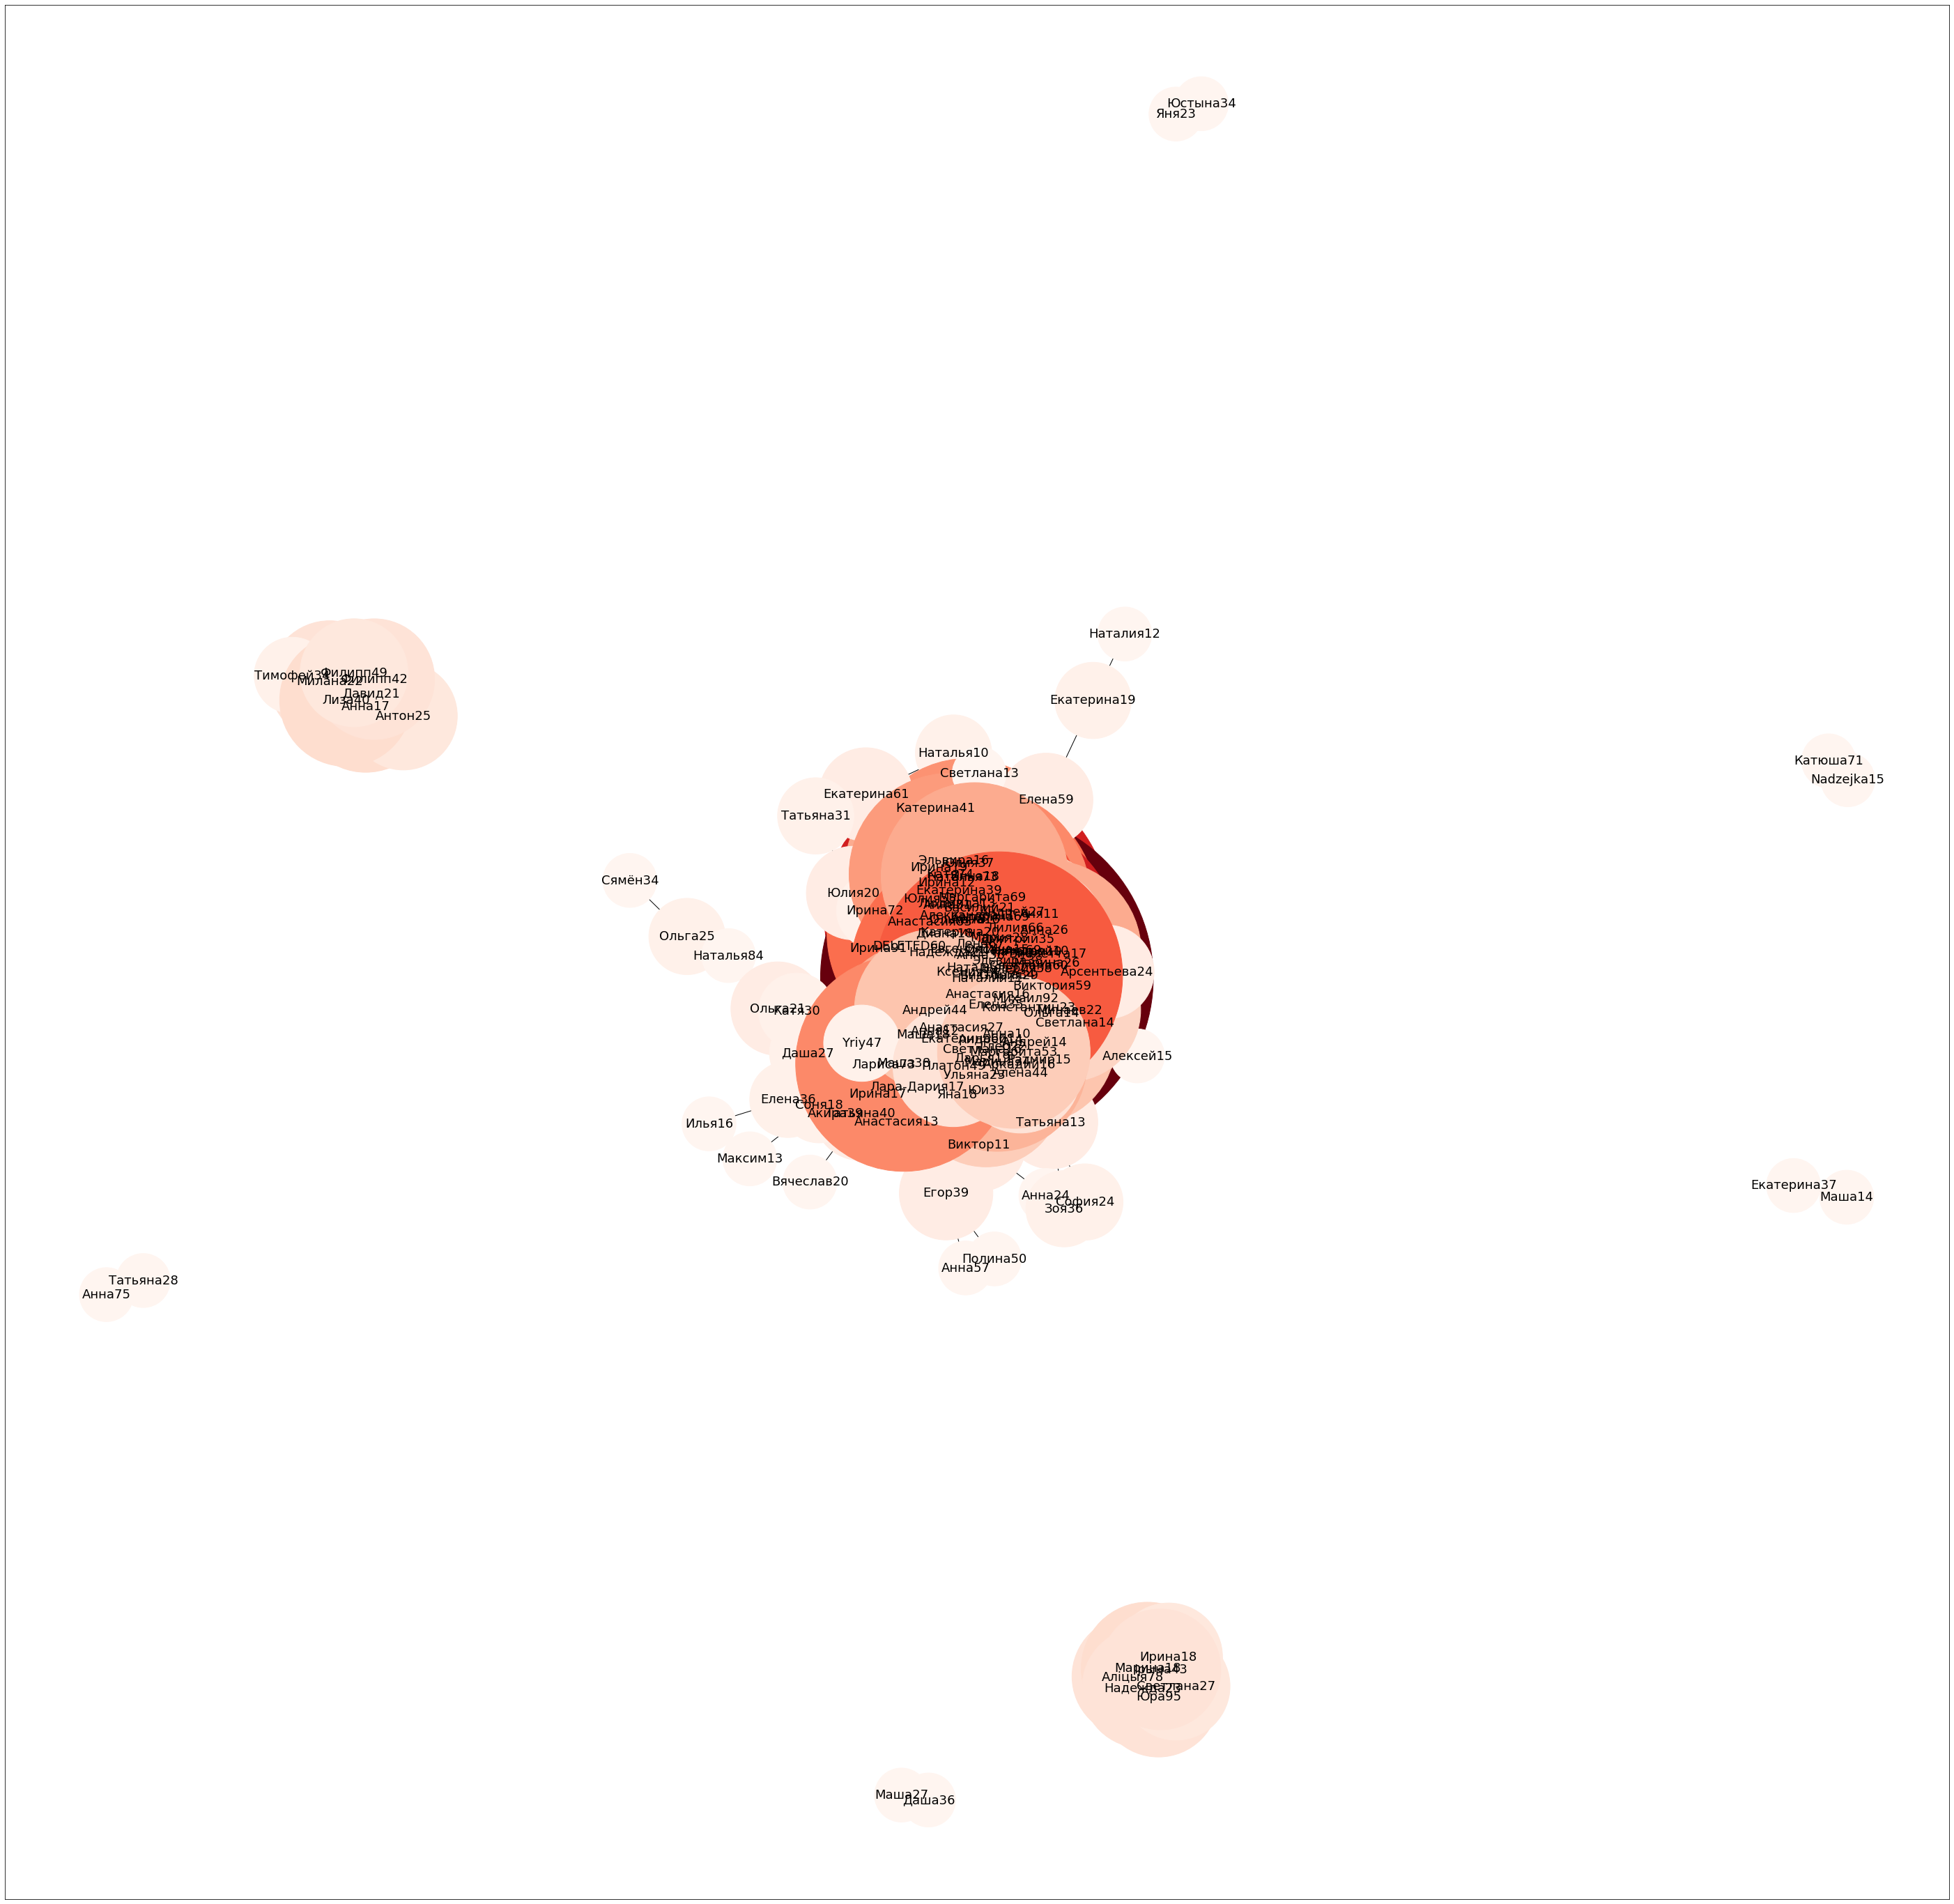

In [14]:
k = dict(nx.degree(G))
plt.figure(1, figsize=(50,50))
coord = nx.spring_layout(G)
nx.draw_networkx(G, pos=coord, nodelist=list(k.keys()),
                 node_size = [d*6000 for d in k.values()], node_color=list(k.values()),font_size=18,
                 cmap=plt.cm.Reds,with_labels=True,labels = lbls)

##### The graph rendered via Gephi

In [15]:
display(Image(url="vk_cleaned.svg", width=740, height=160, unconfined=True)) 

### Network metrics
* Degree distribution
* Diameter
* Clustering Coefficient

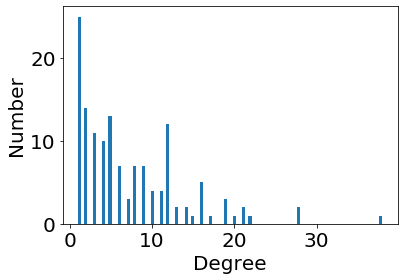

Max degree: 38
Mean degree: 7.260869565217392
Diameter: 8
Clustering Coefficient: 0.41444426039423554


In [17]:
def get_metrics(graph):
    dginfo = list(dict((x, y) for x, y in nx.degree(graph)).values())
    gm = list(graph.subgraph(c) for c in nx.connected_components(graph))
    gm.sort(key=lambda c: c.size(), reverse=True)
    # degrees, max, mean, diameter, cc    
    return dginfo, max(dginfo), np.mean(dginfo), nx.diameter(gm[0]), nx.transitivity(graph)

dgrs, max_d, mean_d, g_dm, clust_c = get_metrics(G)

# show node degrees
plt.xlabel('Degree')
plt.ylabel('Number')
plt.hist(dgrs, 100)
plt.show()
print ("Max degree:", max_d)
print ("Mean degree:", mean_d)

print ("Diameter:", g_dm)
print ("Clustering Coefficient:", clust_c)

## 2. Structural Analysis

### Centralities

In [18]:
def top2lbl(data, sz):
    return [lbls[x] for x in sorted(data, key = data.get, reverse=True)[:sz]]

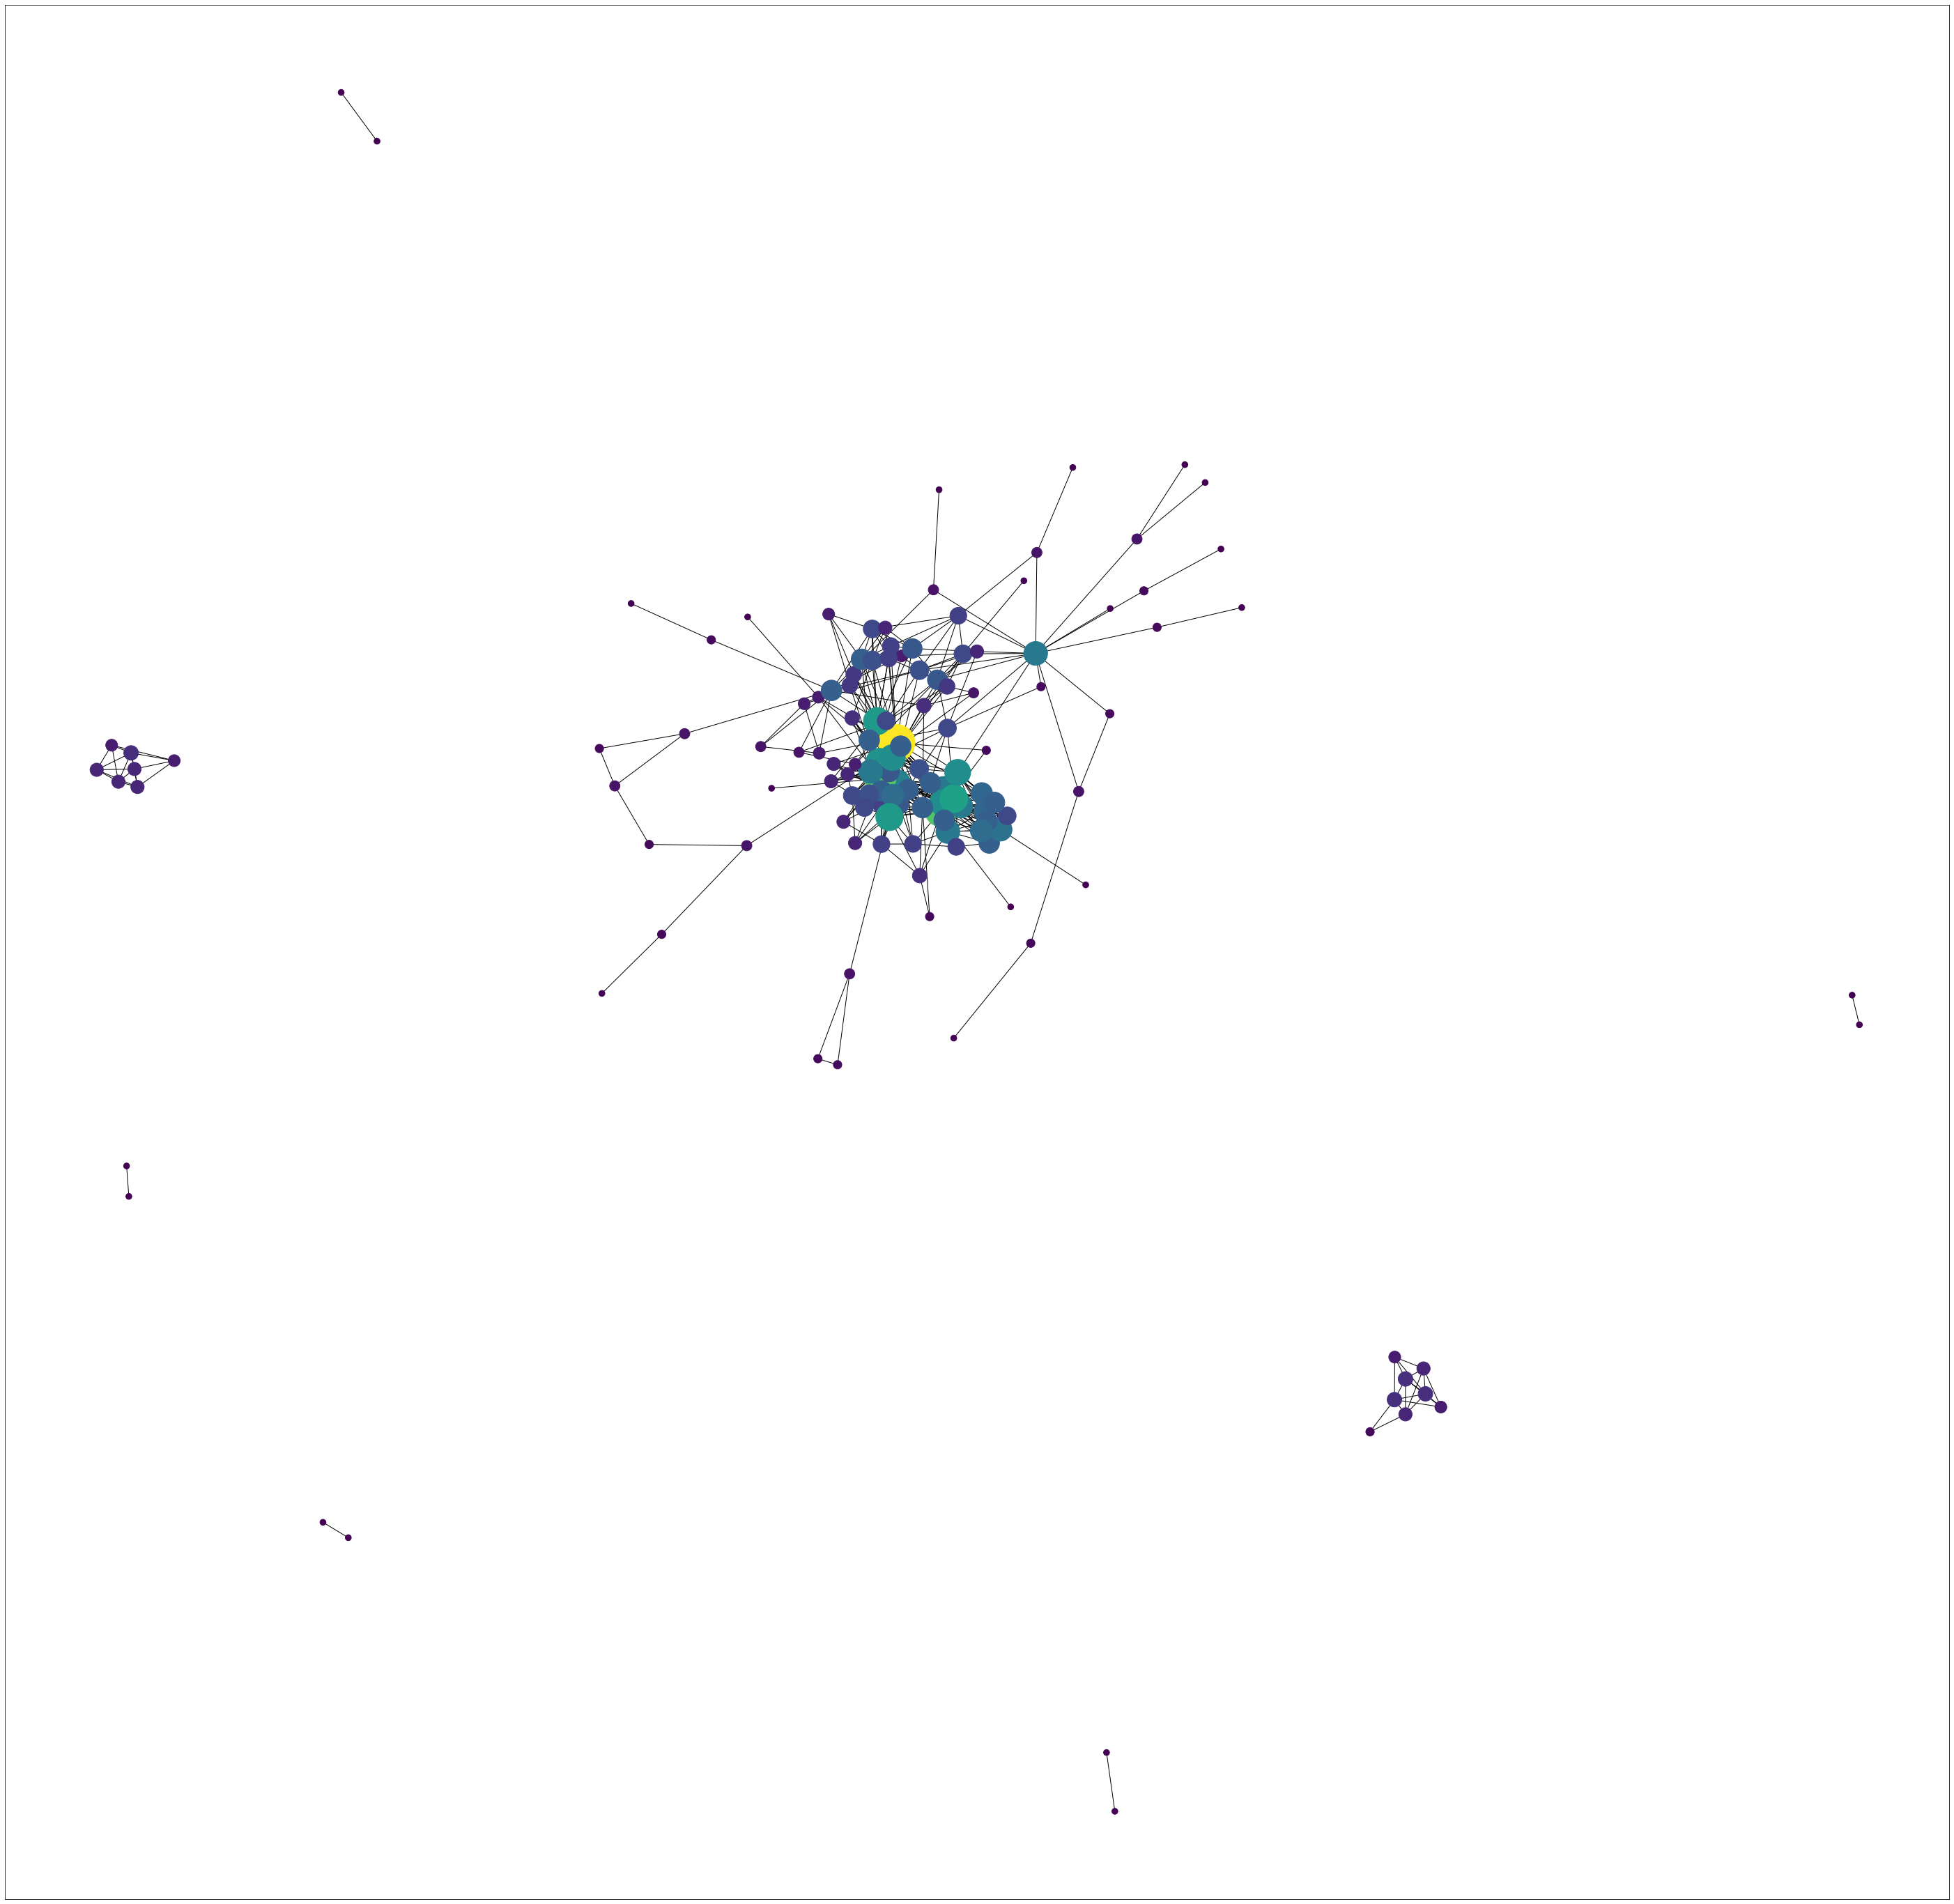

In [54]:
#nx.betweenness_centrality(G)
# Degree centrality
dc = nx.degree_centrality(G)
# plt.figure(1, figsize=(10,7))
plt.figure(1, figsize=(50,50))
nx.draw_networkx(G,
          pos,
          nodelist=list(dc.keys()),
          node_size = [d*10000 for d in dc.values()],
          node_color=list(dc.values()),
          labels = lbls,
          font_size=30,
          font_color='red',
            with_labels=False
          )
plt.show()

In [20]:
# Closeness centrality
cc = nx.closeness_centrality(G)

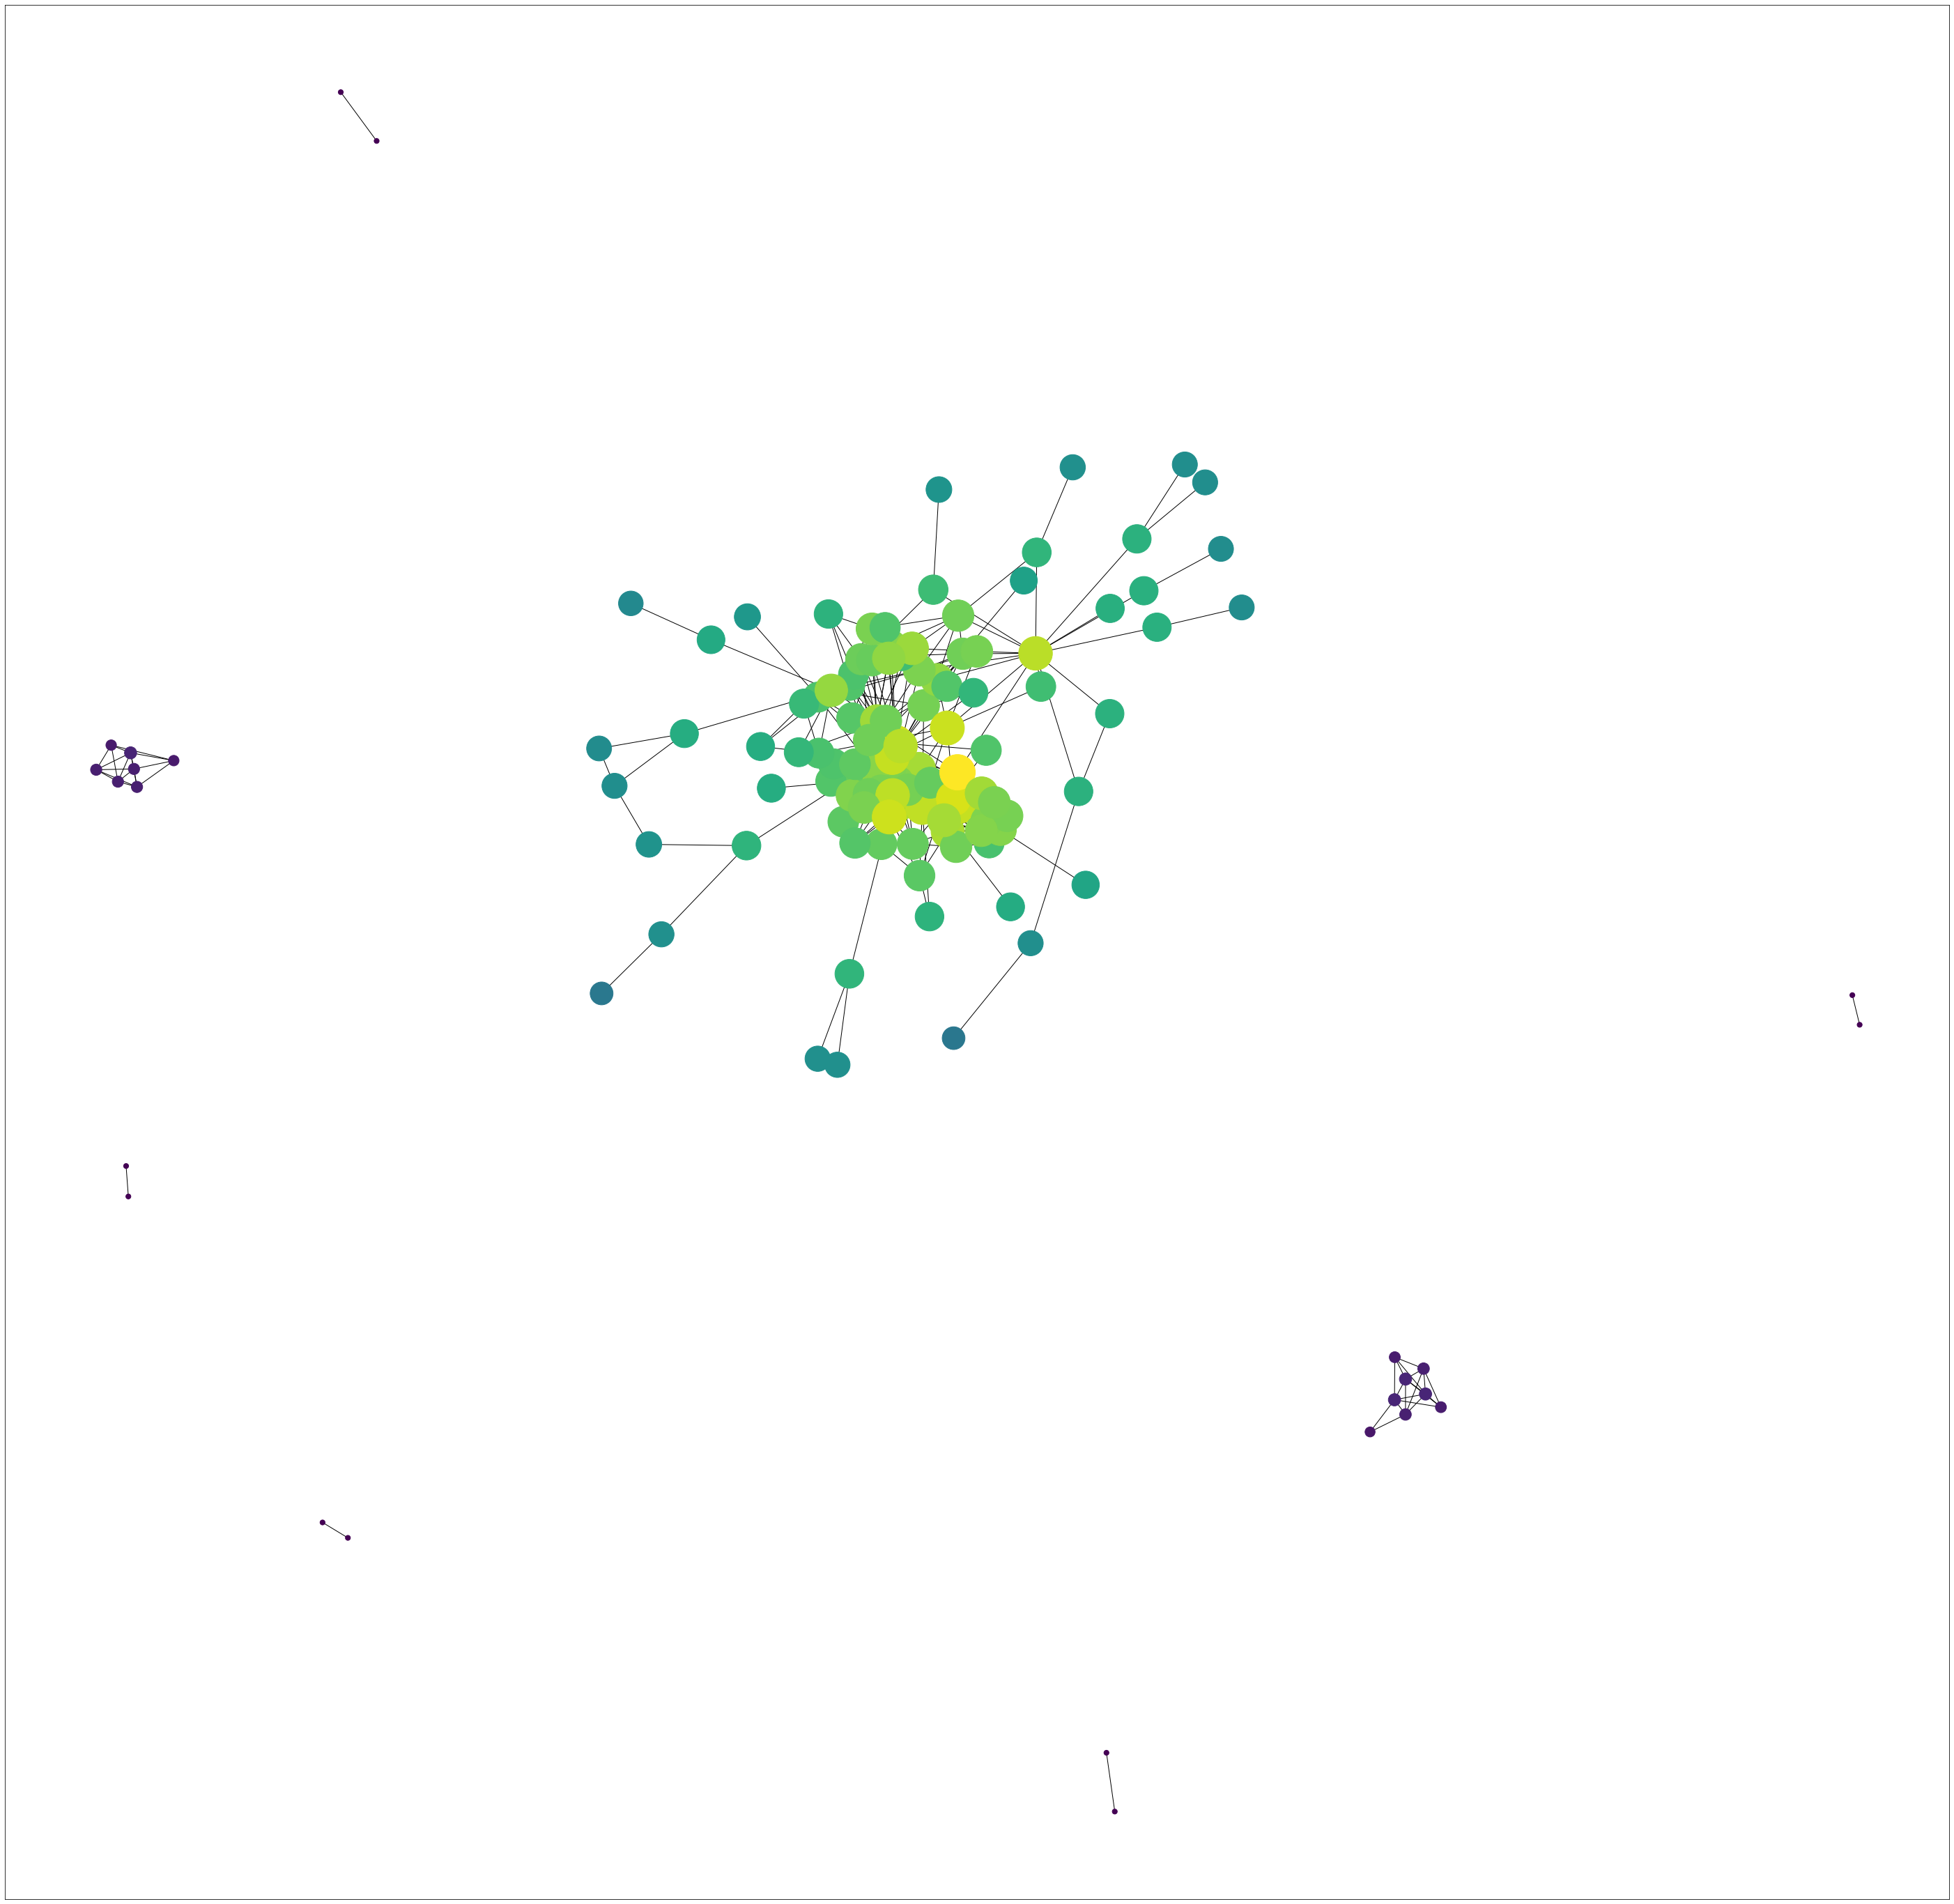

In [56]:
plt.figure(1, figsize=(50,50))
nx.draw_networkx(G,
          pos,
          nodelist=list(cc.keys()),
          node_size = [c*7000 for c in cc.values()],
          node_color=list(cc.values()),
          font_size=30,
          font_color='red',
          with_labels=False          
          )
plt.show()

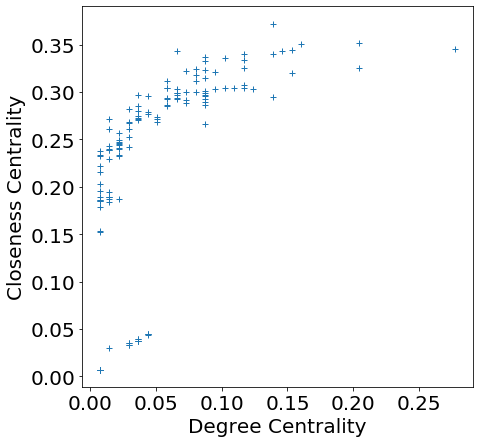

In [22]:
# Plot closeness vs degree centralities
xdata = list(dc.values())
ydata = list(cc.values())
plt.figure(1, figsize=(7,7))
plt.xlabel('Degree Centrality')
plt.ylabel('Closeness Centrality')
p=plt.plot(xdata,ydata, '+')


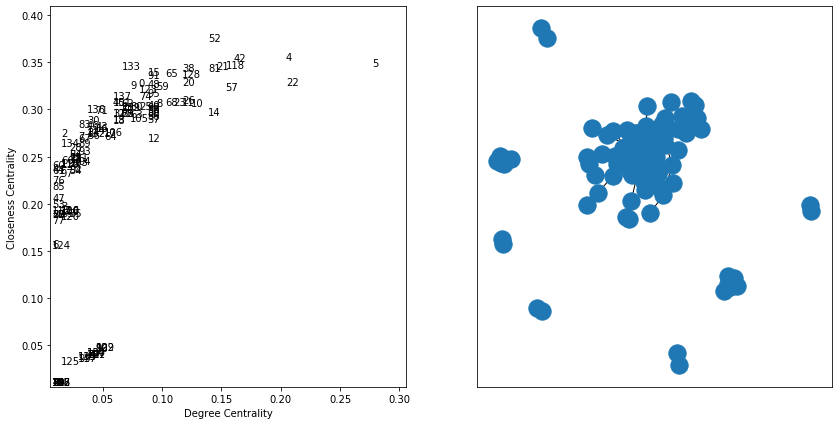

In [62]:
# Adding labels for nodes.
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)
for v in range(len(dc)):
   ax1.text(x = xdata[v], y = ydata[v], s=str(v))
ax1.set_xlim(0.8 * min(xdata), 1.1 * max(xdata))
ax1.set_ylim(0.8 * min(ydata), 1.1 * max(ydata))
ax1.set_xlabel('Degree Centrality')
ax1.set_ylabel('Closeness Centrality')

ax2 = fig.add_subplot(122)
ax2 = nx.draw_networkx(G, pos, labels = lbls, with_labels=False)

In [24]:
# Span of degree centrality (aka xdata)
max(xdata)-min(xdata)

0.27007299270072993

In [25]:
# Span of closeness centrality (aka ydata)
max(ydata)-min(ydata)

0.364904159990505

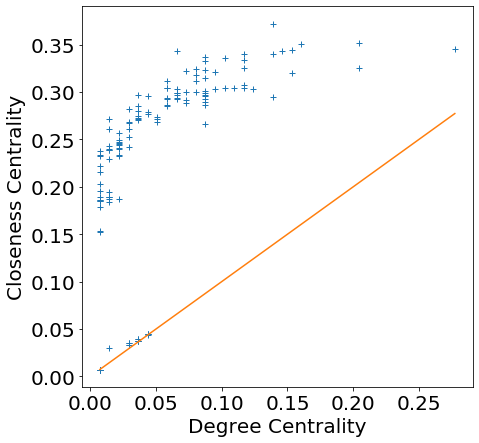

In [26]:
# Plot closeness vs degree centralities with an added line!
xdata = list(dc.values())
ydata = list(cc.values())
plt.figure(1, figsize=(7,7))
plt.xlabel('Degree Centrality')
plt.ylabel('Closeness Centrality')
p=plt.plot(xdata,ydata, '+')
x=np.arange(min(xdata),max(xdata),0.01)
p=plt.plot(x,x)

In [27]:
bc = nx.betweenness_centrality(G)

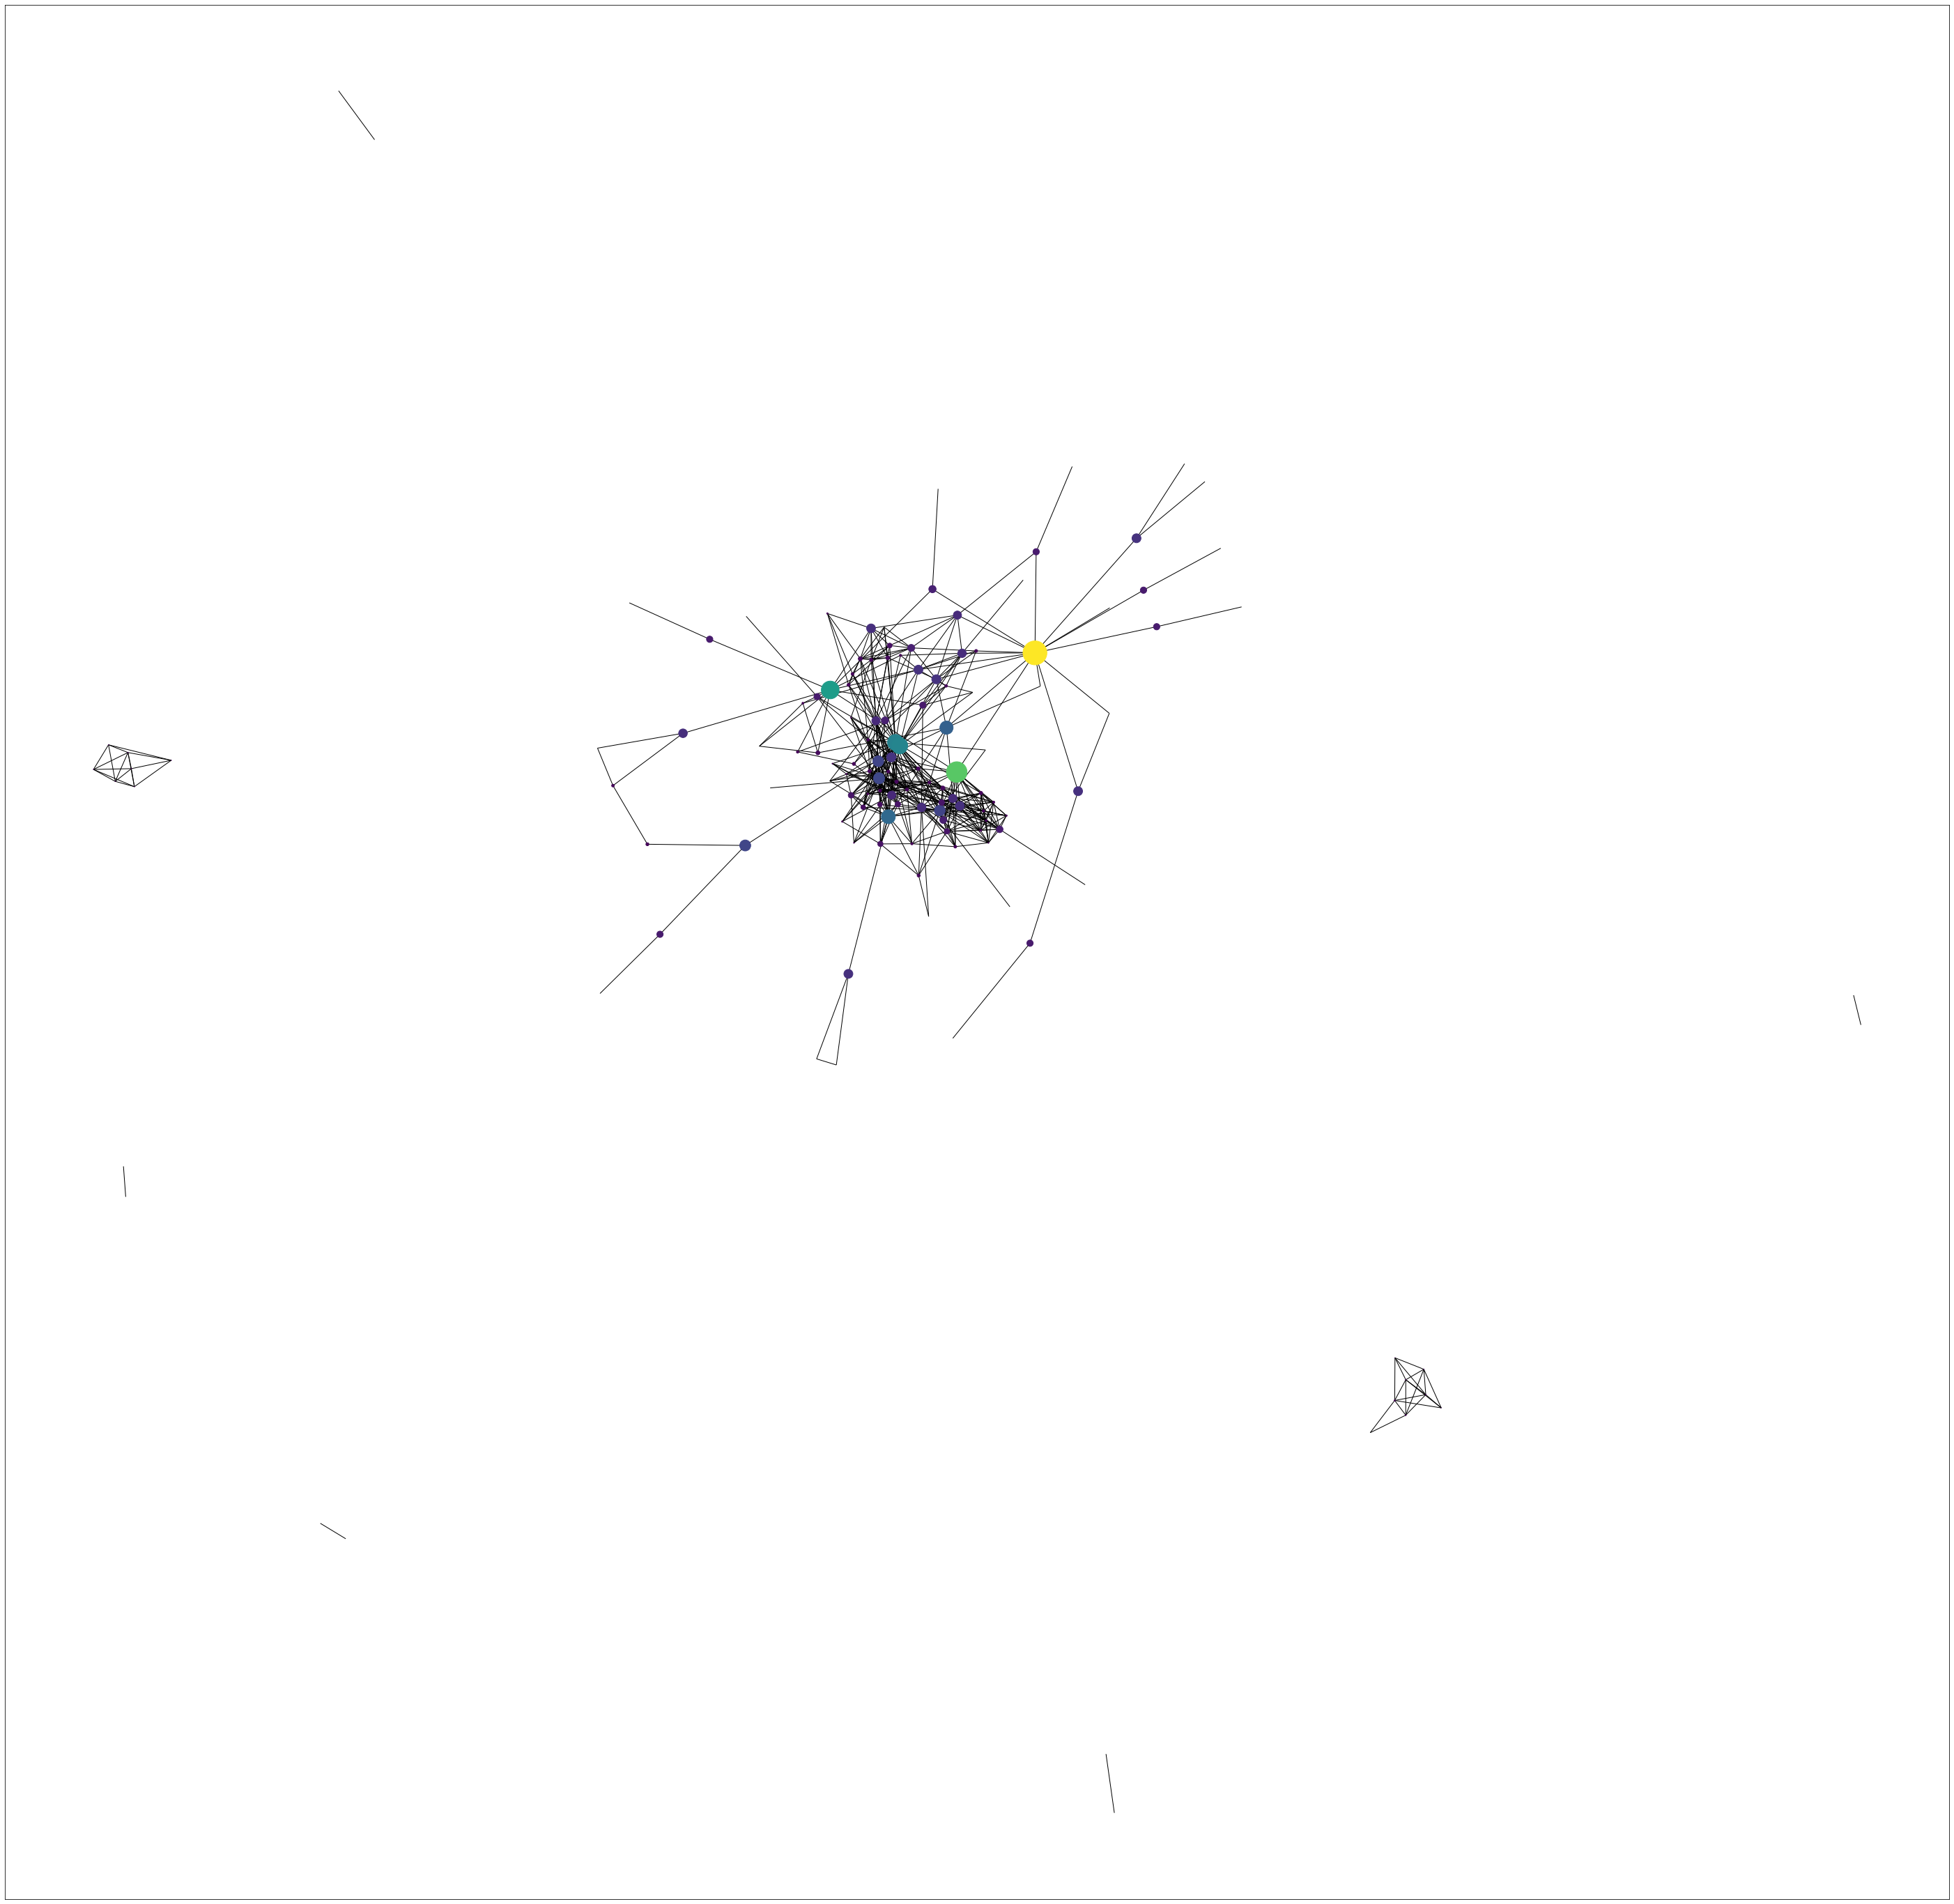

In [58]:
plt.figure(1, figsize=(50,50))
nx.draw_networkx(G,
          pos,
          nodelist=list(cc.keys()),
          node_size = [c*7000 for c in bc.values()],
          node_color=list(bc.values()),
          font_size=30,
          font_color='red',          
            with_labels=False
          )
plt.show()

#### Very connected people / Degree c.

In [28]:
top2lbl(dc, 3)

['Наталия11', 'Александра11', 'Анна36']

####  People who could most quickly influence the whole network / Closeness c.

In [29]:
top2lbl(cc, 3)

['Диана18', 'Александра11', 'Ольга78']

####  People who bridging the flow at most /  / Betweenness c.

In [30]:
top2lbl(bc, 3)

['Маша38', 'Диана18', 'Маша18']

### PageRank

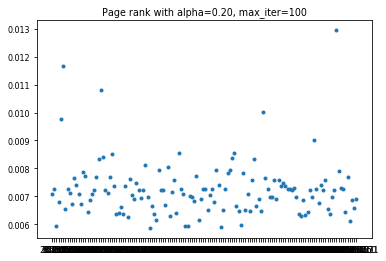

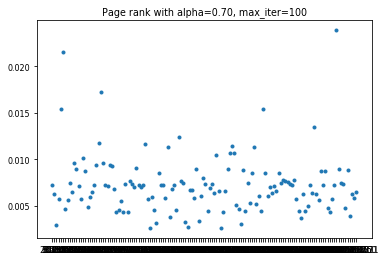

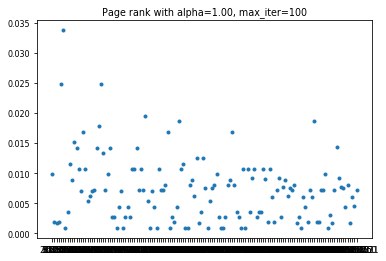

In [31]:
def plotResults(G, alpha, iterations):
    page_rank = nx.pagerank(G, alpha, max_iter=iterations)
    pr = top2lbl(page_rank, 3)
    
    plt.title("Page rank with alpha=%.2f, max_iter=%d" % (alpha, iterations))
    plt.plot(list(page_rank.keys()), list(page_rank.values()), '.')
    plt.show()
    return pr
plt.rcParams.update({'font.size': 8})
it = 100
prs = {}
for alpha in [0.2, 0.7, 1]:
    prs[alpha] = plotResults(G, alpha, it)

In [32]:
for key, value in prs.items():
    print("Alpha:", key, ". Users: ", value)

Alpha: 0.2 . Users:  ['Маша38', 'Наталия11', 'Анна36']
Alpha: 0.7 . Users:  ['Маша38', 'Наталия11', 'Анна36']
Alpha: 1 . Users:  ['Наталия11', 'Анна36', 'Александра11']


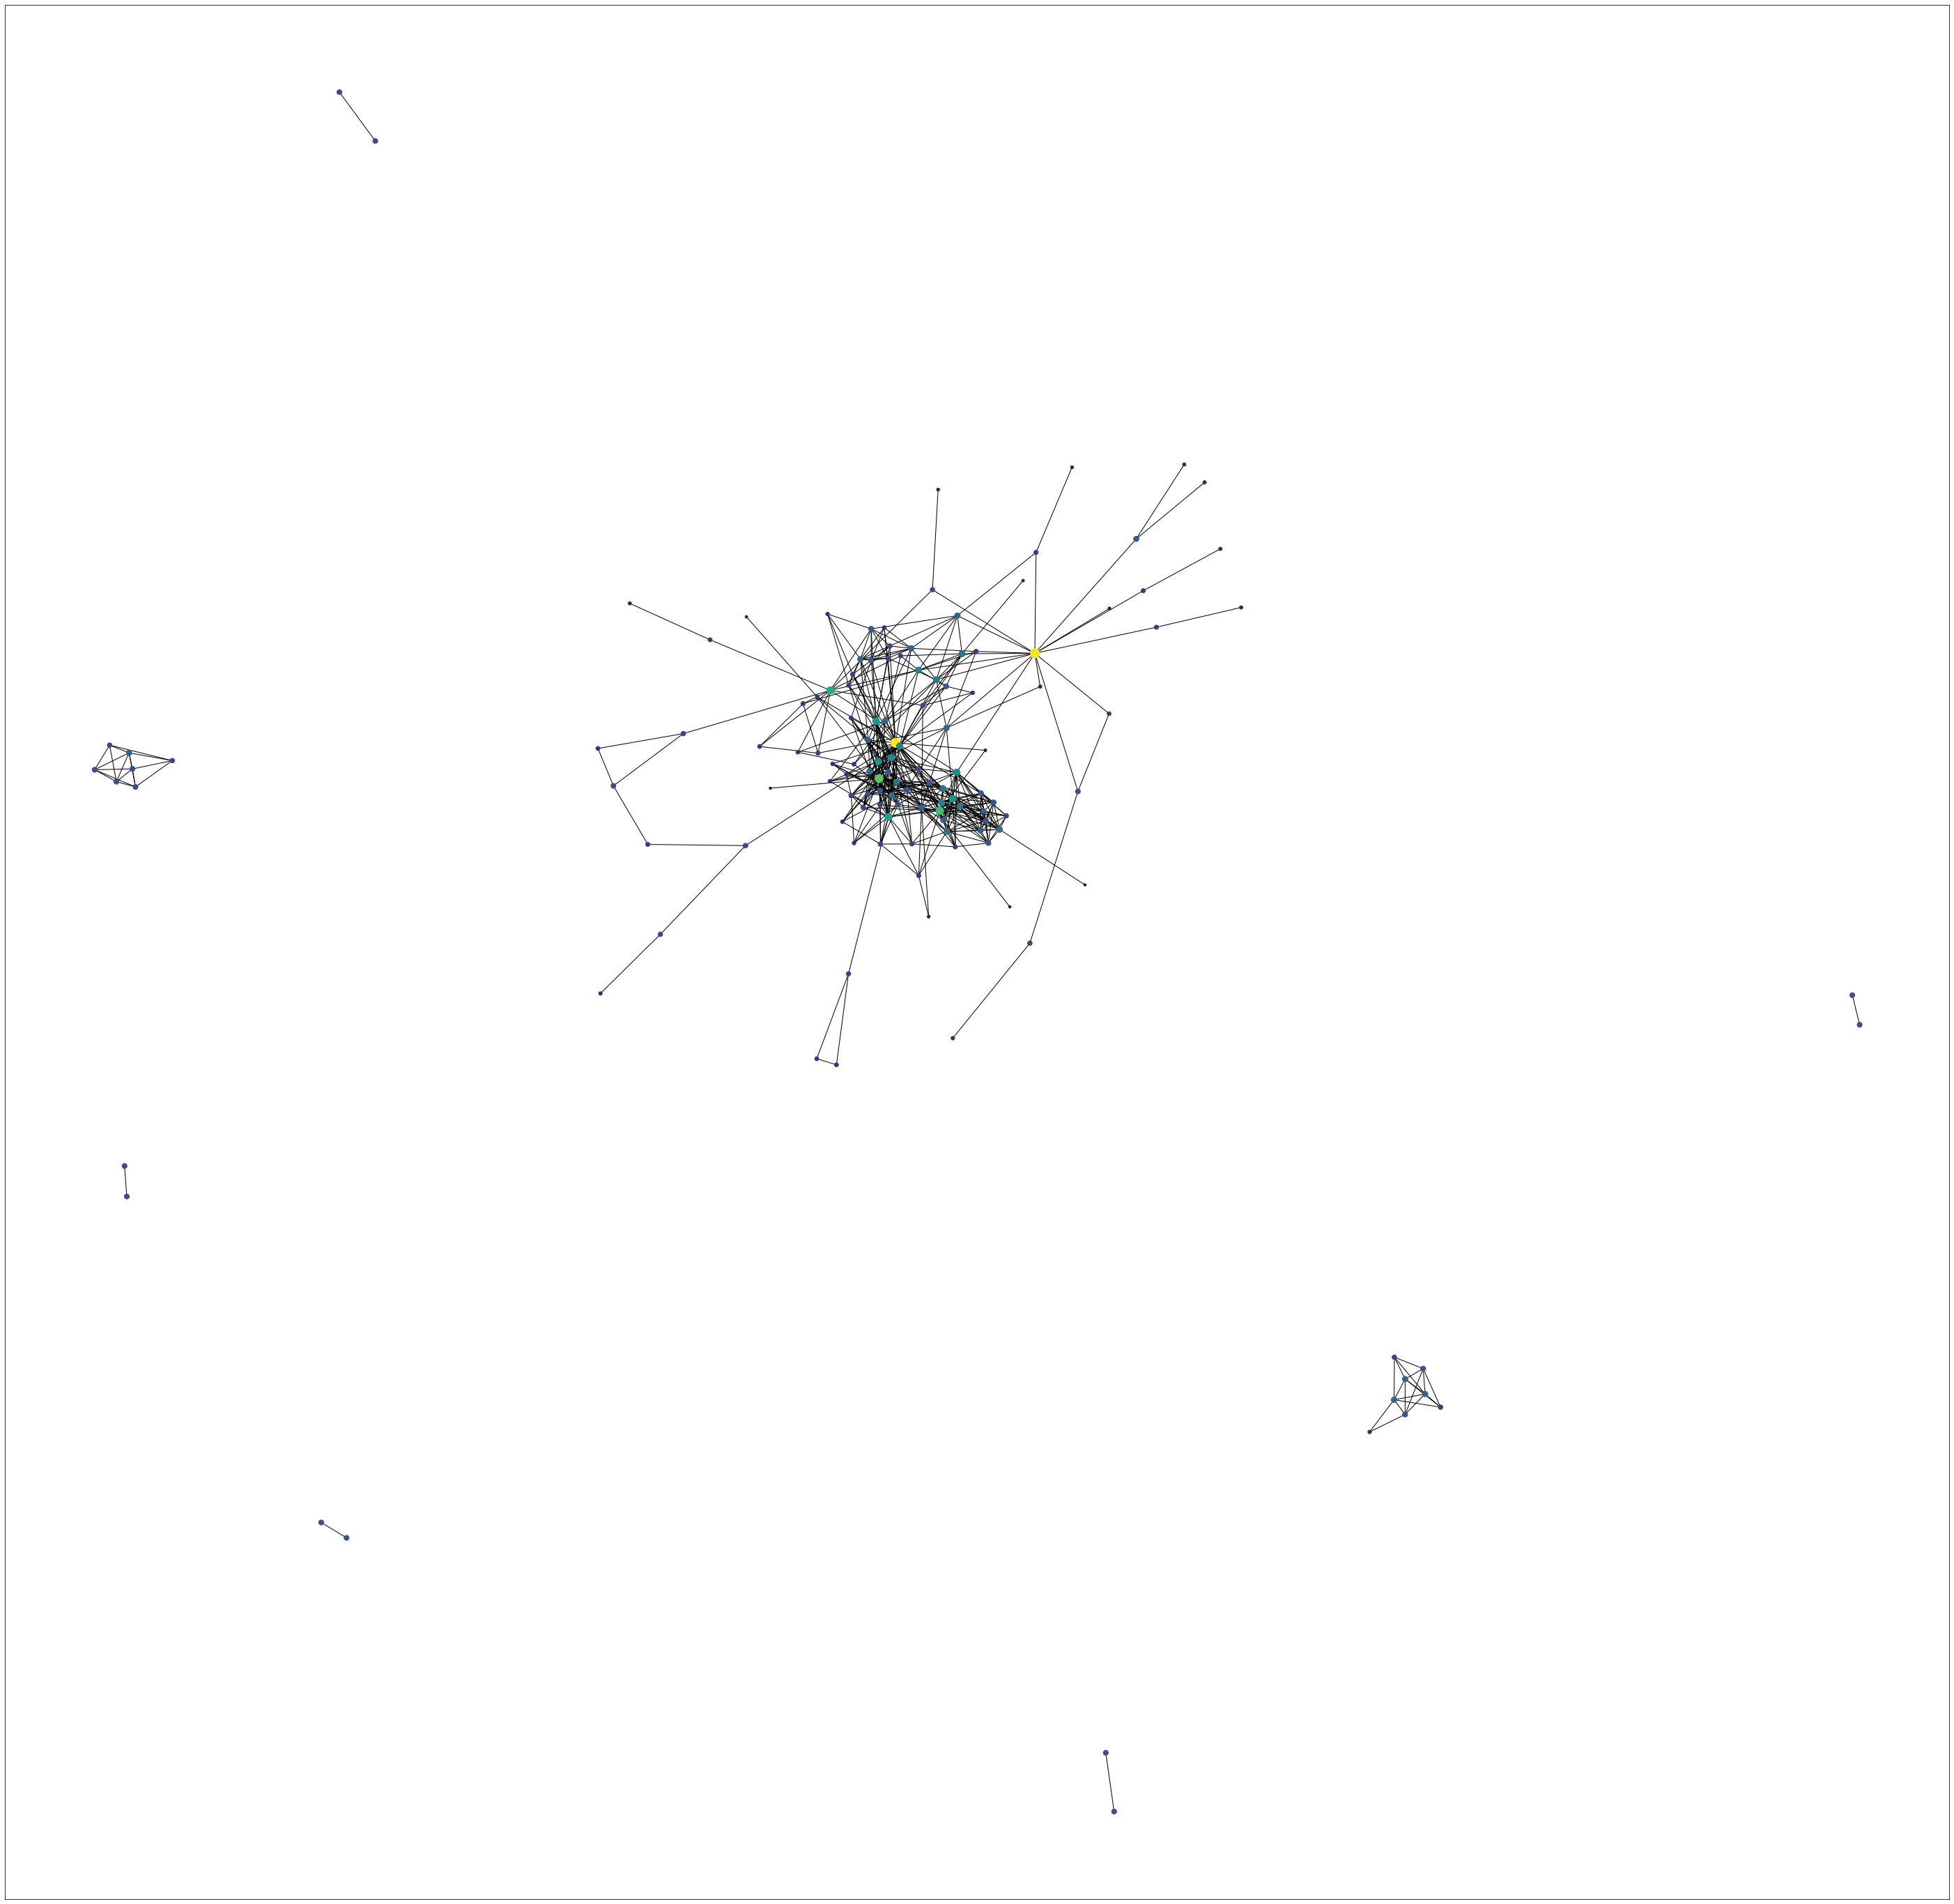

In [60]:
pr = nx.pagerank(G)
plt.figure(1, figsize=(50,50))
nx.draw_networkx(G,
          pos,
          nodelist=list(pr.keys()),
          node_size = [c*7000 for c in pr.values()],
          node_color=list(pr.values()),
          font_size=30,
          font_color='red',          
            with_labels=False
          )
plt.show()

**Looking on the results, one can say that with these data, PR seems to be is similar to degree centrality and betweenness centrality**

#### Assortativity

As soon as we have only one consistent attribute gender(sex), we can look how it influences connections in the graph.

In [61]:
print("Degree assortativity", nx.degree_assortativity_coefficient(G))

Degree assortativity 0.15828346967187903


In [33]:
print(nx.numeric_assortativity_coefficient(G,'sex'))

0.10120981419364437


In [34]:
print(nx.attribute_mixing_matrix(G, "sex"))

[[0.7245509  0.11876248]
 [0.11876248 0.03792415]]


This attribute seems to be not really influential

#### Structural Similarity

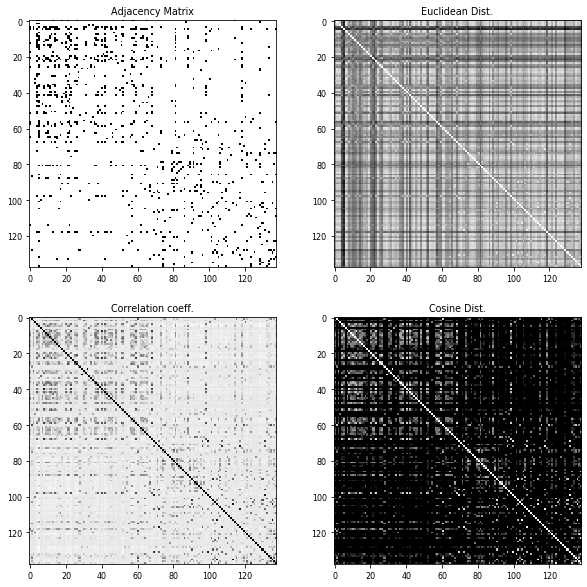

In [35]:
import scipy.spatial as spt
def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')
    
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)
plotDist(A)   

#### Random graphs comparision

In [36]:
nq = len(nx.nodes(G))
BA = nx.barabasi_albert_graph(nq, 7)
RR = nx.random_regular_graph(7, nq)
GNM = nx.gnm_random_graph(nq, 501)

In [37]:
print(nx.info(BA))
#  max, mean, diameter, cc    
metrics_ba = get_metrics(BA)[1:]
print(metrics_ba)

print(nx.info(RR))
metrics_rr = get_metrics(RR)[1:]
print(metrics_rr)


print(nx.info(GNM))
metrics_gnm = get_metrics(GNM)[1:]
print(metrics_gnm)

Name: 
Type: Graph
Number of nodes: 138
Number of edges: 917
Average degree:  13.2899
(45, 13.289855072463768, 3, 0.15814036977203375)
Name: 
Type: Graph
Number of nodes: 138
Number of edges: 483
Average degree:   7.0000
(7, 7.0, 4, 0.043478260869565216)
Name: 
Type: Graph
Number of nodes: 138
Number of edges: 501
Average degree:   7.2609
(13, 7.260869565217392, 5, 0.05661995996568487)


|Metrics  | Original  | Barabasi-Albert  |  Rand.reg | GNM
|---|---|---|---|---|
|Nodes| 138 |138   |138   |138 
|Edges|   501|917   |483   |501   
|Mean degree|  7.3 | 13.2  | 7  |   7.3
|Clust. coef.| 0.41  |  0.16 |  0.038 |  0.04
|Diameter|8   |   3| 4  |   5

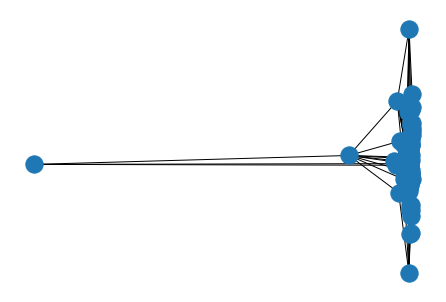

In [38]:
nx.draw_spectral(BA)

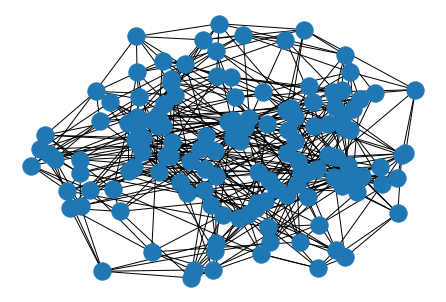

In [39]:
nx.draw_spectral(RR)

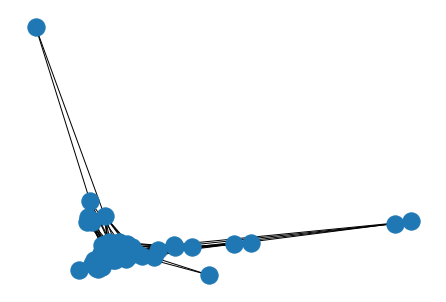

In [40]:
nx.draw_spectral(GNM)

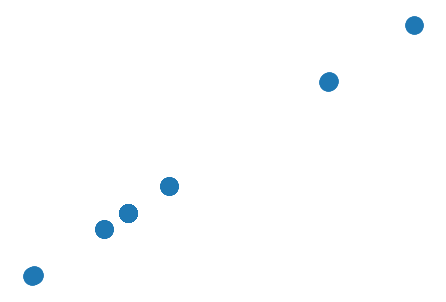

In [41]:
nx.draw_spectral(G)

###### Despite there is no identical graph was generated via random graph algorithms, one could say that *Random Regular Graph* is the most similar to ours. 

## 3. Community Detection

In [42]:
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)

In [43]:
def render_com(graph, data, ttl):

    pos = nx.kamada_kawai_layout(graph)
    # pos = nx.spring_layout(G,k=0.15,iterations=20)
    coms_n = len(data)
    cmcustom = cm.get_cmap('Paired', coms_n)

    plt.figure(1, figsize=(50,50))


    for i, com in enumerate (data):    
        nx.draw_networkx_nodes(graph, pos, com, node_size = 1000, node_color = convert_to_hex(cmcustom(i)))
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph,pos, labels= lbls, with_labels=True, font_size=25)
    plt.rcParams.update({'font.size': 40})
    plt.title("Communities inside the friends graph ("+ str(coms_n) +")" + ", " + ttl)

    plt.show()
    pass

### Cliques

In [44]:
# from networkx.algorithms.community import k_clique_communities
gen_cliq = nx.find_cliques(G)
print ("Maximum number of cliques is", len(list(gen_cliq)))

Maximum number of cliques is 215


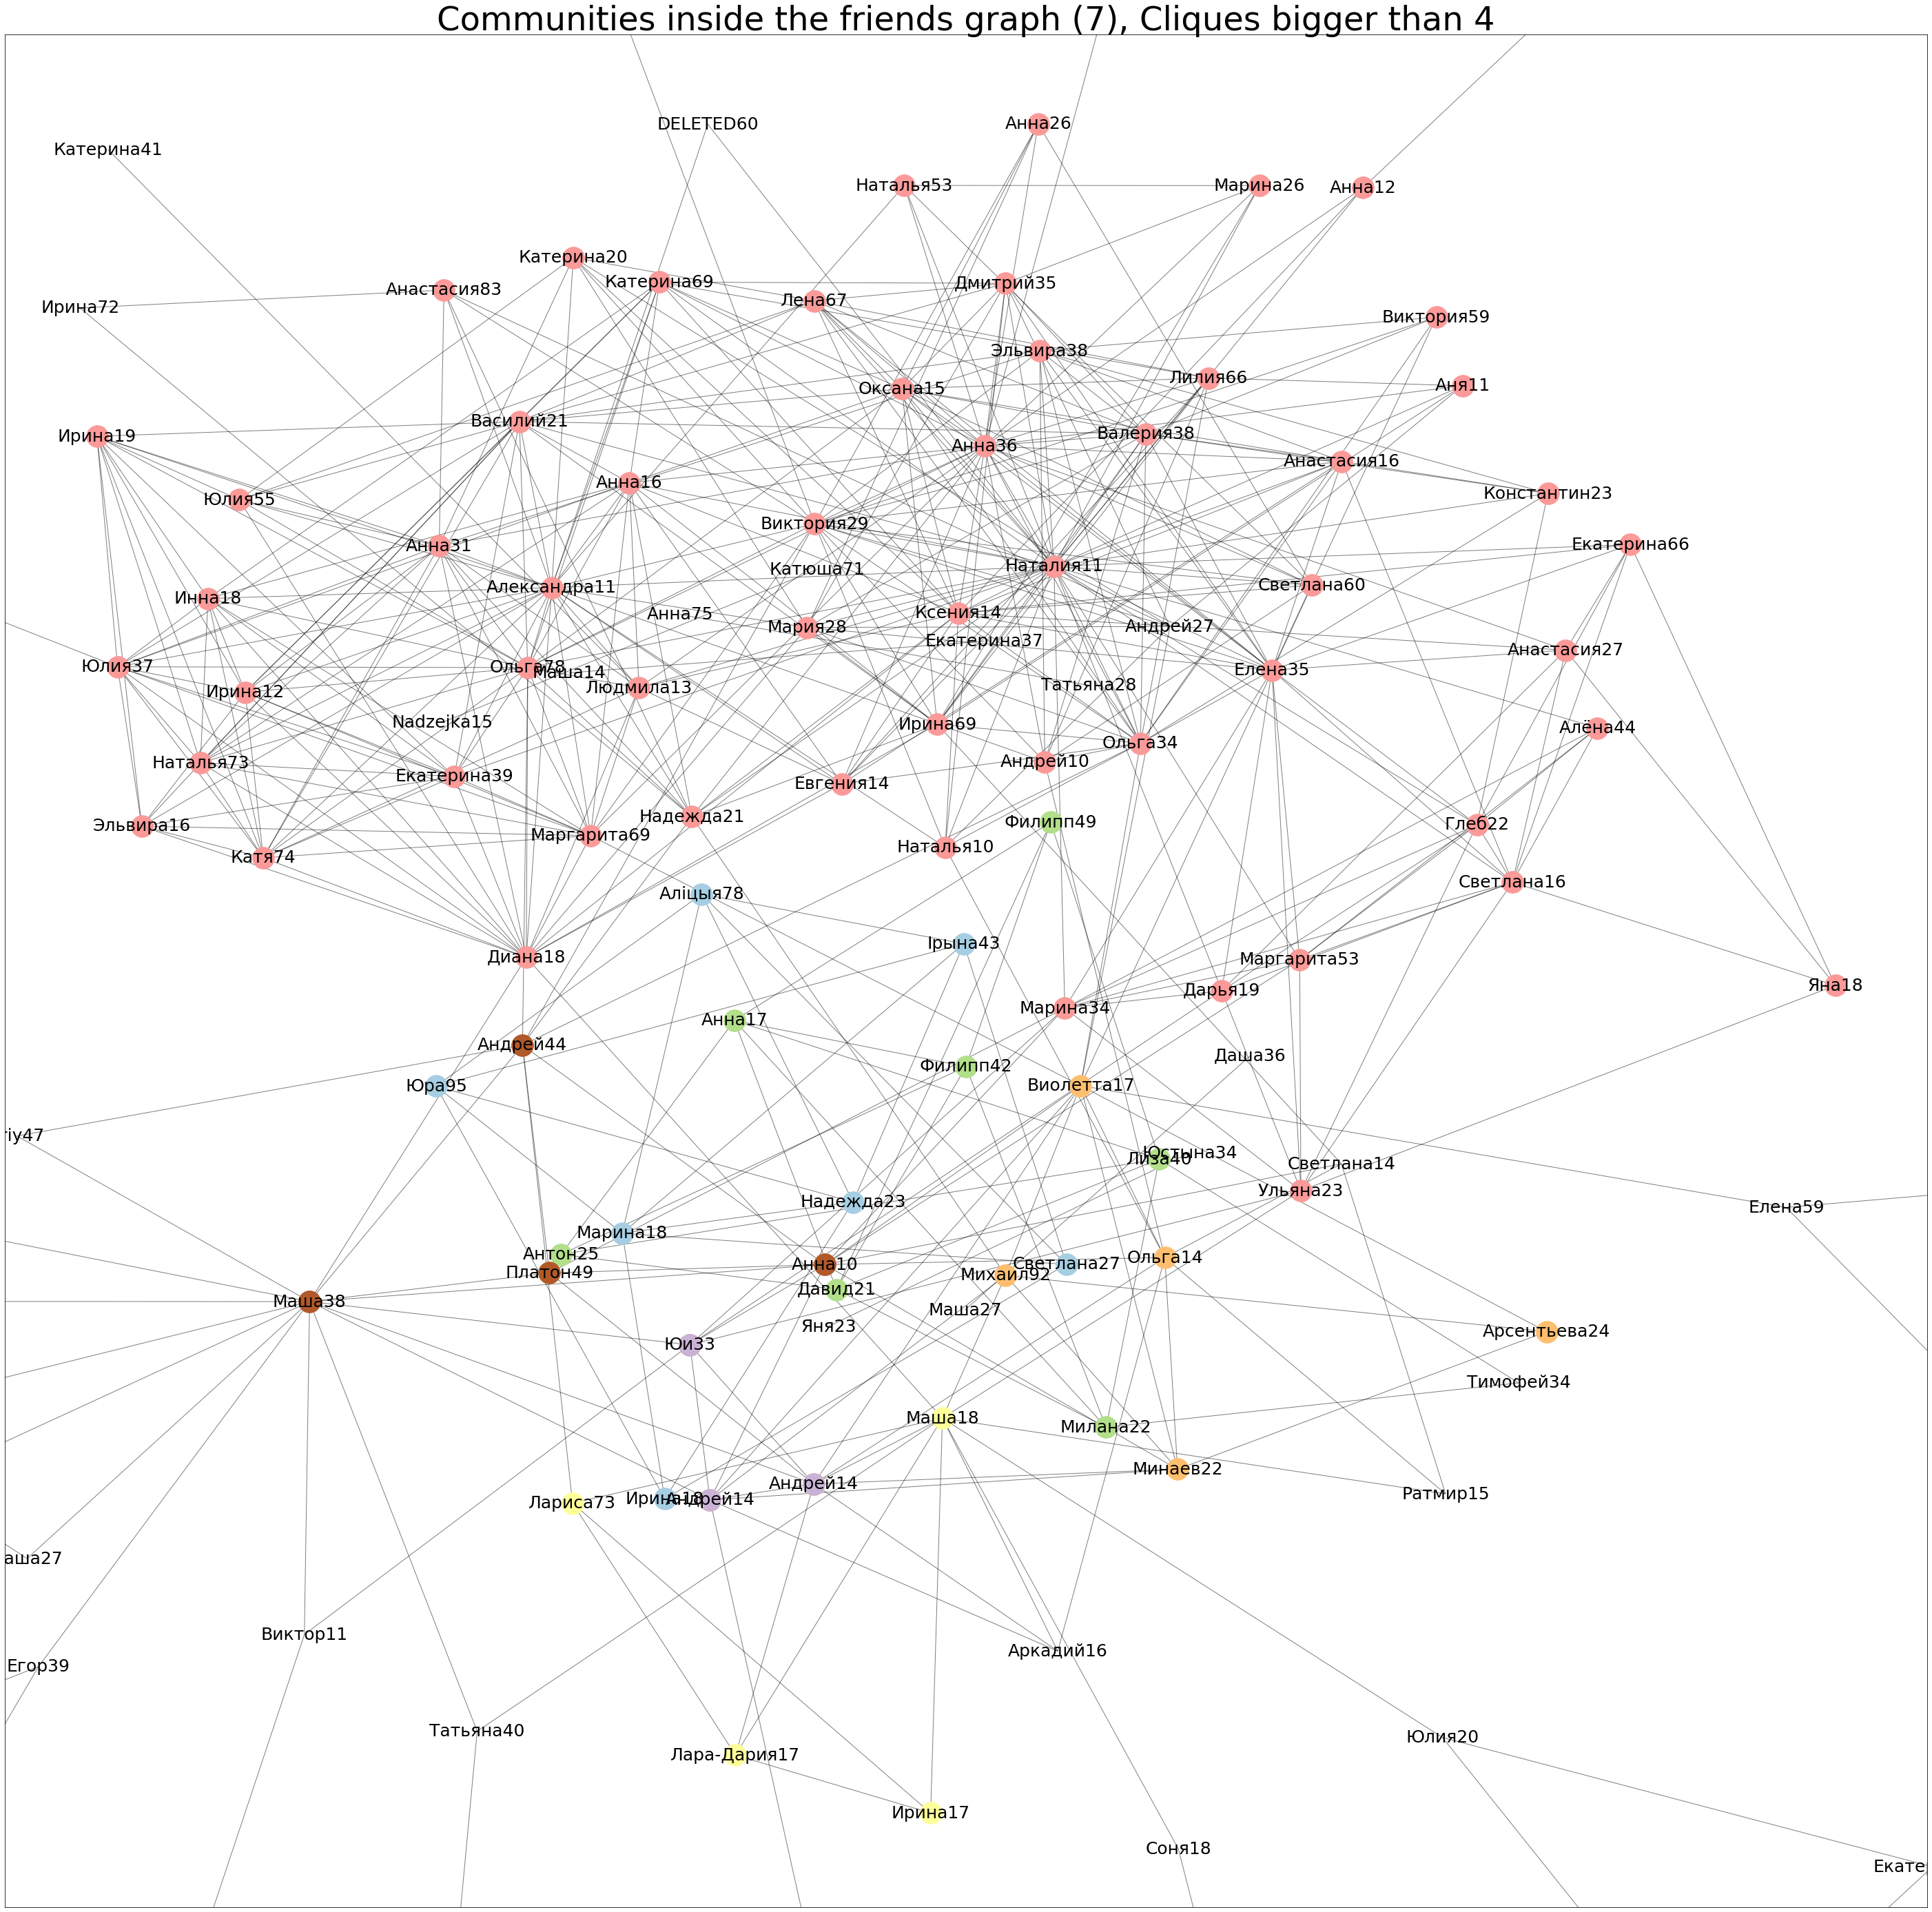

In [50]:
render_com(G, list(nx.algorithms.community.k_clique_communities(G, 4)), "Cliques bigger than 4")

### Clauset-Newman-Moore greedy modularity maximization (NetworkX)

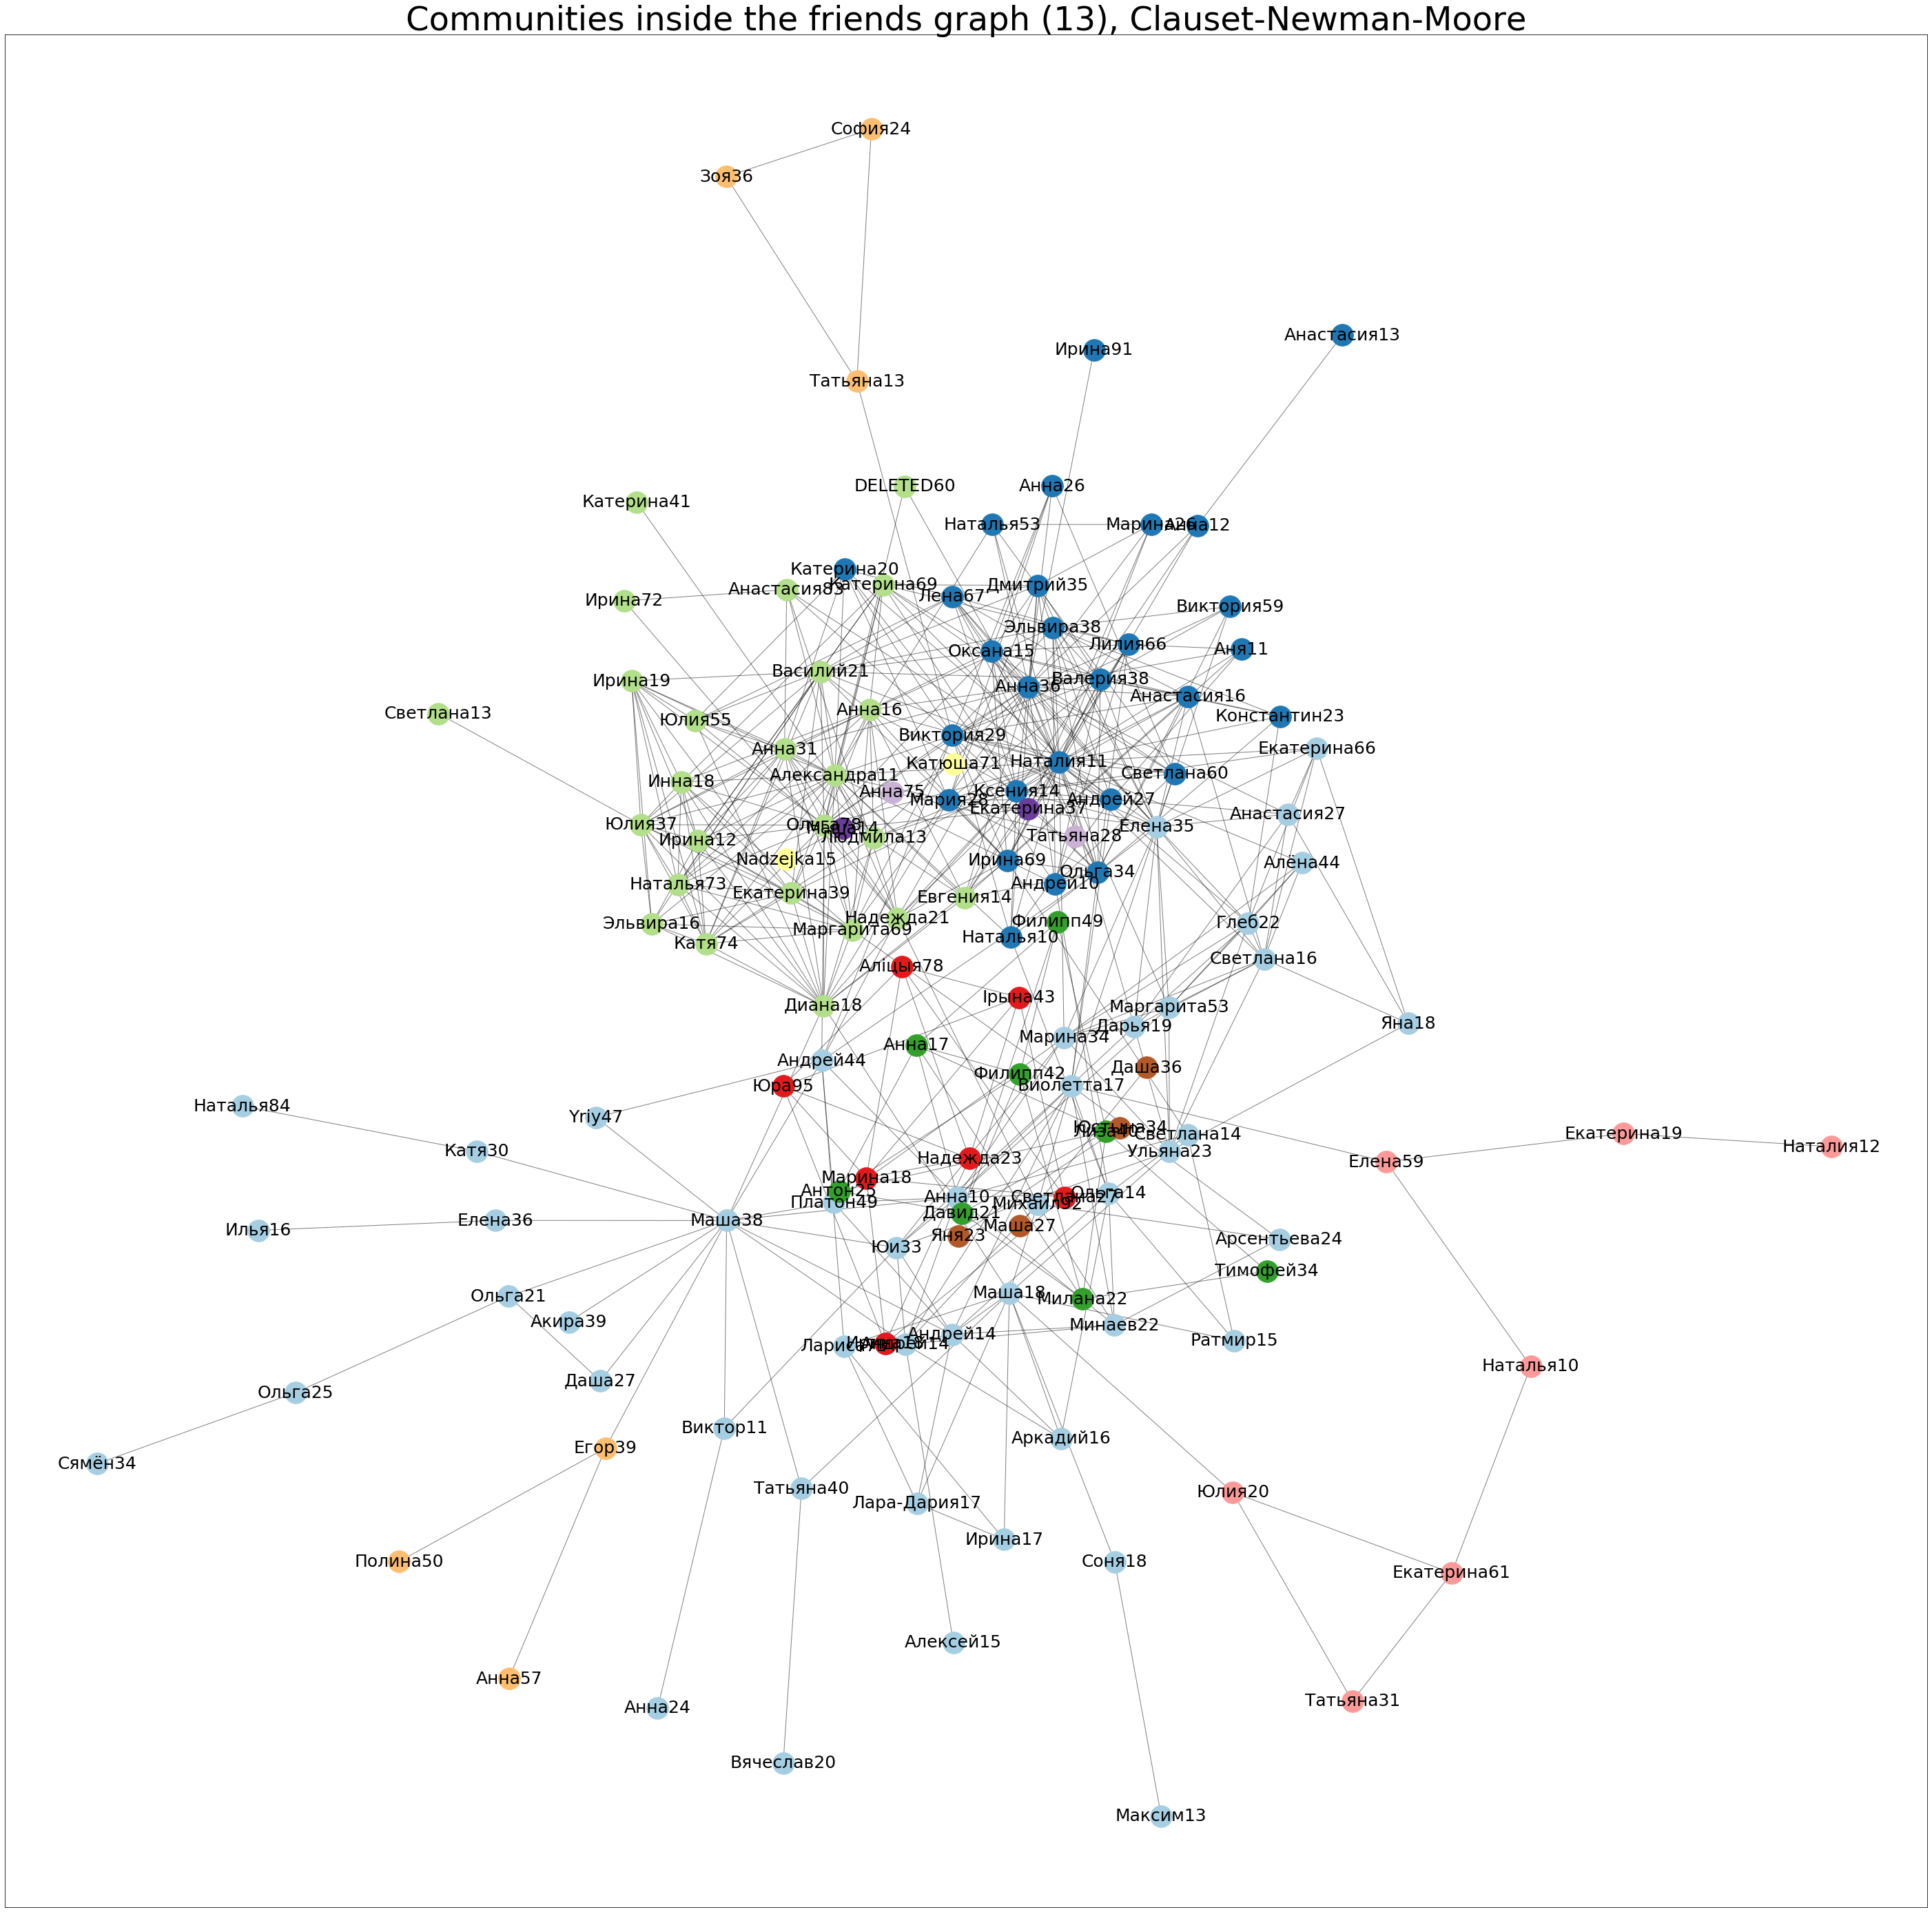

In [46]:
render_com(G, nxcom.greedy_modularity_communities(G), "Clauset-Newman-Moore")

### Louvain Community Detection (Python-Louvain aka Community) 

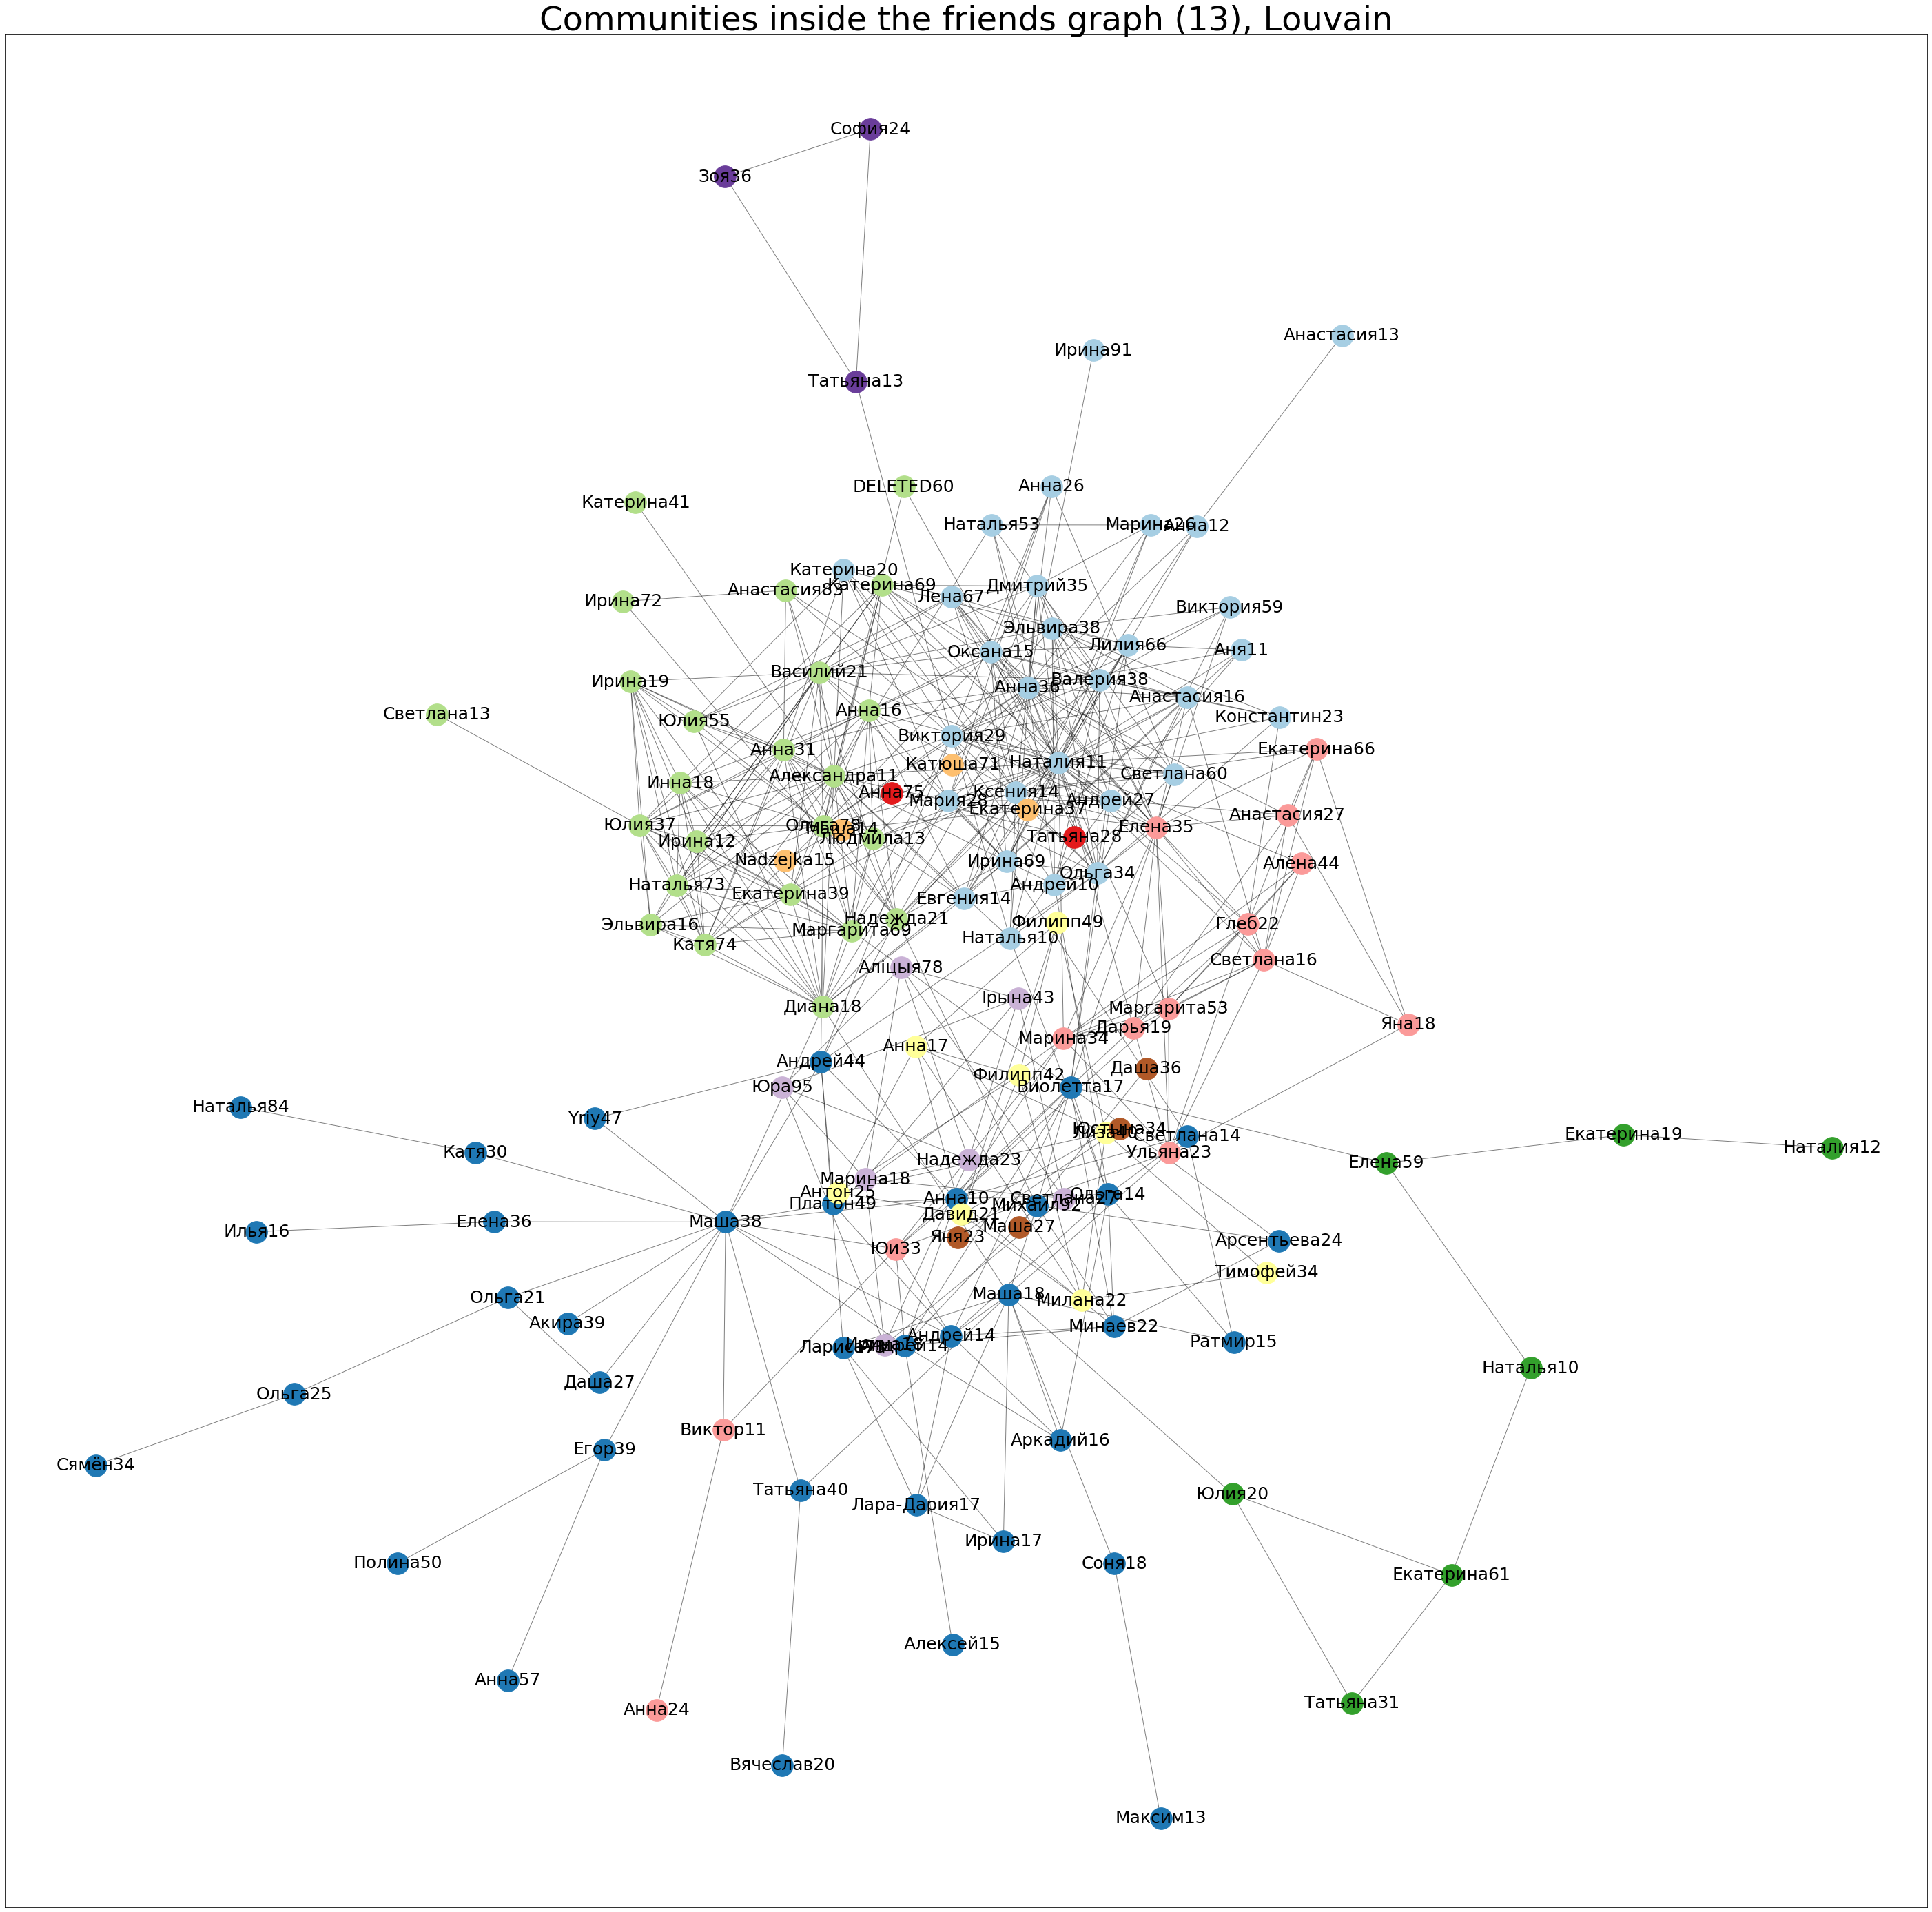

In [47]:
com_dict = defaultdict(list)
for d, z in community.best_partition(G).items(): com_dict[z].append(d)
render_com(G, com_dict.values(), "Louvain")

### Gephi community detection based on modularity (on full graph, without dropping out isolates)

In [48]:
display(Image(url="modular_cleaned.svg", width=740, height=160, unconfined=True)) 